## Imports

In [188]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import torch
from numpy.random import seed
seed_value = 420 
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,classification_report,roc_auc_score,roc_curve,recall_score, average_precision_score
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance
import boost_histogram as bh
from sklearn.model_selection import KFold

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions

### Plotting

In [189]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    ax[1].hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    ax[1].hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    ax[1].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    ax[1].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    ax[1].set_xlabel(xlabel) # write x-axis label
    ax[1].set_ylabel("Arbitrary units") # write y-axis label
    ax[1].legend() # add legend

### Matching

In [190]:
def duplicate_cleaner(matched_pairs, truth=None):
    truth_ids = matched_pairs['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]
    clean_pairs = matched_pairs[no_repeats]
    if truth is not None:
        duplicate_truth = truth[one_repeat]
        return clean_pairs, duplicate_pairs, duplicate_truth
    
    return clean_pairs, duplicate_pairs, no_repeats

def duplicate_matcher(repeat, dupe_truth):
    fixable_repeats = repeat[ak.num(repeat)>2]

    repeat_truth, valid_particles, duplicate_particles = [], [], []

    for i in range(1,len(dupe_truth[0])+1):

        repeat_ids = fixable_repeats['truth']['id']
        repeat_i = fixable_repeats[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_ids_i = repeat_ids[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_truth.append(dupe_truth[ak.num(repeat_ids[repeat_ids==i], axis=1)==2])

        valid_particles.append(repeat_i[repeat_ids_i!=i])
        duplicate_particles.append(repeat_i[repeat_ids_i==i])


    repeat_truth = ak.concatenate(repeat_truth)
    valid_particles = [ak.concatenate(valid_particles)]
    duplicate_particles = ak.concatenate(duplicate_particles)
    id = np.tile(np.arange(1,len(repeat_truth[0])+1), (len(repeat_truth),1))
    repeat_truth_zip = ak.zip({'truth': repeat_truth, 'id': id})

    duplicate_deltars = duplicate_particles['reco'].deltaR(duplicate_particles['truth']['truth'])
    min_dupdeltars = ak.min(duplicate_deltars, axis=1)

    valid_particles.append(duplicate_particles[duplicate_deltars==min_dupdeltars])
    invalid_particles = duplicate_particles['reco'][duplicate_deltars!=min_dupdeltars]

    second_pass = ak.cartesian({'reco': invalid_particles, 'truth': repeat_truth_zip})
    second_deltars = second_pass['reco'].deltaR(second_pass['truth']['truth'])

    second_smallest_dr = ak.sort(second_deltars)[:,1]
    valid_particles.append(second_pass[(second_deltars==second_smallest_dr)&(second_smallest_dr<0.4)])
    valid_particles = ak.concatenate(valid_particles, axis=1)
    return valid_particles

def truth_matching(truth, truth_id, reco_jets, reco_leptons):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    indexed_truth = ak.zip({'truth': truth, 'id': id})
    
    truth_jets = indexed_truth[truth_id < 10]
    truth_leptons = indexed_truth[(truth_id > 10)&(truth_id<20)]

    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)

    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_jets = ak.flatten(jets_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)


    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)

    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_leptons = ak.flatten(leptons_3d[(deltars==min_deltars)&(min_deltars<0.1)], axis=2)

    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)

    matched_pairs, repeat_pairs, matched_bools = duplicate_cleaner(matched)

    #valid_particles = duplicate_matcher(repeat_pairs, repeat_truth)

    #matched_events = ak.concatenate((matched_pairs, valid_particles), axis=0)
    matched_events = matched_pairs
    
    return matched_events, matched_bools

def top_identifier(matched_data, process, top_channel, lepton_channel, lepton_indices=None, at_least=False):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":
        tops_1 = matched_data[(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
        tops_2 = matched_data[(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
        tops_3 = matched_data[(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
        tops_4 = matched_data[(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]
        if lepton_channel == "0L":

            if top_channel == 'sm':

                if at_least:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)]
                    matched_tops_2 = tops_2[(ak.num(tops_2)==3)]
                    matched_tops_3 = tops_3[(ak.num(tops_3)==3)]
                    matched_tops_4 = tops_4[(ak.num(tops_4)==3)]

                else:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)!=3)&(ak.num(tops_4)!=3)]
                    matched_tops_2 = tops_2[(ak.num(tops_1)!=3)&(ak.num(tops_2)==3)&(ak.num(tops_3)!=3)&(ak.num(tops_4)!=3)]
                    matched_tops_3 = tops_3[(ak.num(tops_1)!=3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)==3)&(ak.num(tops_4)!=3)]
                    matched_tops_4 = tops_4[(ak.num(tops_1)!=3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)!=3)&(ak.num(tops_4)==3)]


                truth_top_1 = ak.sum(matched_tops_1['truth']['truth'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==5)|(matched_tops_1['truth']['id']==6)], axis=1)
                truth_top_2 = ak.sum(matched_tops_2['truth']['truth'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==7)|(matched_tops_2['truth']['id']==8)], axis=1)
                truth_top_3 = ak.sum(matched_tops_3['truth']['truth'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==9)|(matched_tops_3['truth']['id']==10)], axis=1)
                truth_top_4 = ak.sum(matched_tops_4['truth']['truth'][(matched_tops_4['truth']['id']==4)|(matched_tops_4['truth']['id']==11)|(matched_tops_4['truth']['id']==12)], axis=1)

                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4))

                reco_top_1 = ak.sum(matched_tops_1['reco'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==5)|(matched_tops_1['truth']['id']==6)], axis=1)
                reco_top_2 = ak.sum(matched_tops_2['reco'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==7)|(matched_tops_2['truth']['id']==8)], axis=1)
                reco_top_3 = ak.sum(matched_tops_3['reco'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==9)|(matched_tops_3['truth']['id']==10)], axis=1)
                reco_top_4 = ak.sum(matched_tops_4['reco'][(matched_tops_4['truth']['id']==4)|(matched_tops_4['truth']['id']==11)|(matched_tops_4['truth']['id']==12)], axis=1)

                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4))

                return sm_truth_tops, sm_reco_tops

            elif top_channel == 'fm':

                fully_matched_events = matched_data[(ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3)]
                truth_top_1 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)], axis=1),1)
                truth_top_4 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)], axis=1),1)

                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)], axis=1),1)
                reco_top_4 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)], axis=1),1)

                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1)

                return fm_truth_tops, fm_reco_tops

            elif top_channel == 'tm':
                triple_matched_events_123 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3))&(ak.num(matched_data)<12)]
                tm_123_truth_top_1 = ak.sum(triple_matched_events_123['truth']['truth'][(triple_matched_events_123['truth']['id']==1)|(triple_matched_events_123['truth']['id']==5)|(triple_matched_events_123['truth']['id']==6)], axis=1)
                tm_123_truth_top_2 = ak.sum(triple_matched_events_123['truth']['truth'][(triple_matched_events_123['truth']['id']==2)|(triple_matched_events_123['truth']['id']==7)|(triple_matched_events_123['truth']['id']==8)], axis=1)
                tm_123_truth_top_3 = ak.sum(triple_matched_events_123['truth']['truth'][(triple_matched_events_123['truth']['id']==3)|(triple_matched_events_123['truth']['id']==9)|(triple_matched_events_123['truth']['id']==10)], axis=1)

                tm_123_reco_top_1 = ak.sum(triple_matched_events_123['reco'][(triple_matched_events_123['truth']['id']==1)|(triple_matched_events_123['truth']['id']==5)|(triple_matched_events_123['truth']['id']==6)], axis=1)
                tm_123_reco_top_2 = ak.sum(triple_matched_events_123['reco'][(triple_matched_events_123['truth']['id']==2)|(triple_matched_events_123['truth']['id']==7)|(triple_matched_events_123['truth']['id']==8)], axis=1)
                tm_123_reco_top_3 = ak.sum(triple_matched_events_123['reco'][(triple_matched_events_123['truth']['id']==3)|(triple_matched_events_123['truth']['id']==9)|(triple_matched_events_123['truth']['id']==10)], axis=1)

                triple_matched_events_124 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
                tm_124_truth_top_1 = ak.sum(triple_matched_events_124['truth']['truth'][(triple_matched_events_124['truth']['id']==1)|(triple_matched_events_124['truth']['id']==5)|(triple_matched_events_124['truth']['id']==6)], axis=1)
                tm_124_truth_top_2 = ak.sum(triple_matched_events_124['truth']['truth'][(triple_matched_events_124['truth']['id']==2)|(triple_matched_events_124['truth']['id']==7)|(triple_matched_events_124['truth']['id']==8)], axis=1)
                tm_124_truth_top_3 = ak.sum(triple_matched_events_124['truth']['truth'][(triple_matched_events_124['truth']['id']==4)|(triple_matched_events_124['truth']['id']==11)|(triple_matched_events_124['truth']['id']==12)], axis=1)

                tm_124_reco_top_1 = ak.sum(triple_matched_events_124['reco'][(triple_matched_events_124['truth']['id']==1)|(triple_matched_events_124['truth']['id']==5)|(triple_matched_events_124['truth']['id']==6)], axis=1)
                tm_124_reco_top_2 = ak.sum(triple_matched_events_124['reco'][(triple_matched_events_124['truth']['id']==2)|(triple_matched_events_124['truth']['id']==7)|(triple_matched_events_124['truth']['id']==8)], axis=1)
                tm_124_reco_top_3 = ak.sum(triple_matched_events_124['reco'][(triple_matched_events_124['truth']['id']==4)|(triple_matched_events_124['truth']['id']==11)|(triple_matched_events_124['truth']['id']==12)], axis=1)

                triple_matched_events_134 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
                tm_134_truth_top_1 = ak.sum(triple_matched_events_134['truth']['truth'][(triple_matched_events_134['truth']['id']==1)|(triple_matched_events_134['truth']['id']==5)|(triple_matched_events_134['truth']['id']==6)], axis=1)
                tm_134_truth_top_2 = ak.sum(triple_matched_events_134['truth']['truth'][(triple_matched_events_134['truth']['id']==3)|(triple_matched_events_134['truth']['id']==9)|(triple_matched_events_134['truth']['id']==10)], axis=1)
                tm_134_truth_top_3 = ak.sum(triple_matched_events_134['truth']['truth'][(triple_matched_events_134['truth']['id']==4)|(triple_matched_events_134['truth']['id']==11)|(triple_matched_events_134['truth']['id']==12)], axis=1)

                tm_134_reco_top_1 = ak.sum(triple_matched_events_134['reco'][(triple_matched_events_134['truth']['id']==1)|(triple_matched_events_134['truth']['id']==5)|(triple_matched_events_134['truth']['id']==6)], axis=1)
                tm_134_reco_top_2 = ak.sum(triple_matched_events_134['reco'][(triple_matched_events_134['truth']['id']==3)|(triple_matched_events_134['truth']['id']==9)|(triple_matched_events_134['truth']['id']==10)], axis=1)
                tm_134_reco_top_3 = ak.sum(triple_matched_events_134['reco'][(triple_matched_events_134['truth']['id']==4)|(triple_matched_events_134['truth']['id']==11)|(triple_matched_events_134['truth']['id']==12)], axis=1)

                triple_matched_events_234 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
                tm_234_truth_top_1 = ak.sum(triple_matched_events_234['truth']['truth'][(triple_matched_events_234['truth']['id']==2)|(triple_matched_events_234['truth']['id']==7)|(triple_matched_events_234['truth']['id']==8)], axis=1)
                tm_234_truth_top_2 = ak.sum(triple_matched_events_234['truth']['truth'][(triple_matched_events_234['truth']['id']==3)|(triple_matched_events_234['truth']['id']==9)|(triple_matched_events_234['truth']['id']==10)], axis=1)
                tm_234_truth_top_3 = ak.sum(triple_matched_events_234['truth']['truth'][(triple_matched_events_234['truth']['id']==4)|(triple_matched_events_234['truth']['id']==11)|(triple_matched_events_234['truth']['id']==12)], axis=1)

                tm_234_reco_top_1 = ak.sum(triple_matched_events_234['reco'][(triple_matched_events_234['truth']['id']==2)|(triple_matched_events_234['truth']['id']==7)|(triple_matched_events_234['truth']['id']==8)], axis=1)
                tm_234_reco_top_2 = ak.sum(triple_matched_events_234['reco'][(triple_matched_events_234['truth']['id']==3)|(triple_matched_events_234['truth']['id']==9)|(triple_matched_events_234['truth']['id']==10)], axis=1)
                tm_234_reco_top_3 = ak.sum(triple_matched_events_234['reco'][(triple_matched_events_234['truth']['id']==4)|(triple_matched_events_234['truth']['id']==11)|(triple_matched_events_234['truth']['id']==12)], axis=1)

                tm_truth_top_1 = ak.unflatten(ak.concatenate((tm_123_truth_top_1, tm_124_truth_top_1, tm_134_truth_top_1, tm_234_truth_top_1)),1)
                tm_truth_top_2 = ak.unflatten(ak.concatenate((tm_123_truth_top_2, tm_124_truth_top_2, tm_134_truth_top_2, tm_234_truth_top_2)),1)
                tm_truth_top_3 = ak.unflatten(ak.concatenate((tm_123_truth_top_3, tm_124_truth_top_3, tm_134_truth_top_3, tm_234_truth_top_3)),1)
                tm_truth_tops = ak.concatenate((tm_truth_top_1,tm_truth_top_2,tm_truth_top_3), axis=1)

                tm_reco_top_1 = ak.unflatten(ak.concatenate((tm_123_reco_top_1, tm_124_reco_top_1, tm_134_reco_top_1, tm_234_reco_top_1)),1)
                tm_reco_top_2 = ak.unflatten(ak.concatenate((tm_123_reco_top_2, tm_124_reco_top_2, tm_134_reco_top_2, tm_234_reco_top_2)),1)
                tm_reco_top_3 = ak.unflatten(ak.concatenate((tm_123_reco_top_3, tm_124_reco_top_3, tm_134_reco_top_3, tm_234_reco_top_3)),1)
                tm_reco_tops = ak.concatenate((tm_reco_top_1,tm_reco_top_2,tm_reco_top_3), axis=1)

                return tm_truth_tops, tm_reco_tops

            elif top_channel=='dm':
                double_matched_events_12 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3))&((ak.num(tops_3)!=3)&(ak.num(tops_4)!=3))]
                dm_truth_12_tops_1 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5)|(double_matched_events_12['truth']['id']==6)], axis=1)
                dm_truth_12_tops_2 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7)|(double_matched_events_12['truth']['id']==8)], axis=1)

                dm_reco_12_tops_1 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5)|(double_matched_events_12['truth']['id']==6)], axis=1)
                dm_reco_12_tops_2 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7)|(double_matched_events_12['truth']['id']==8)], axis=1)

                double_matched_events_13 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3))&((ak.num(tops_2)!=3)&(ak.num(tops_4)!=3))]
                dm_truth_13_tops_1 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5)|(double_matched_events_13['truth']['id']==6)], axis=1)
                dm_truth_13_tops_2 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9)|(double_matched_events_13['truth']['id']==10)], axis=1)

                dm_reco_13_tops_1 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5)|(double_matched_events_13['truth']['id']==6)], axis=1)
                dm_reco_13_tops_2 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9)|(double_matched_events_13['truth']['id']==10)], axis=1)

                double_matched_events_14 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_4)==3))&((ak.num(tops_2)!=3)&(ak.num(tops_3)!=3))]
                dm_truth_14_tops_1 = ak.sum(double_matched_events_14['truth']['truth'][(double_matched_events_14['truth']['id']==1)|(double_matched_events_14['truth']['id']==5)|(double_matched_events_14['truth']['id']==6)], axis=1)
                dm_truth_14_tops_2 = ak.sum(double_matched_events_14['truth']['truth'][(double_matched_events_14['truth']['id']==4)|(double_matched_events_14['truth']['id']==11)|(double_matched_events_14['truth']['id']==12)], axis=1)

                dm_reco_14_tops_1 = ak.sum(double_matched_events_14['reco'][(double_matched_events_14['truth']['id']==1)|(double_matched_events_14['truth']['id']==5)|(double_matched_events_14['truth']['id']==6)], axis=1)
                dm_reco_14_tops_2 = ak.sum(double_matched_events_14['reco'][(double_matched_events_14['truth']['id']==4)|(double_matched_events_14['truth']['id']==11)|(double_matched_events_14['truth']['id']==12)], axis=1)

                double_matched_events_23 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_4)!=3))]
                dm_truth_23_tops_1 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7)|(double_matched_events_23['truth']['id']==8)], axis=1)
                dm_truth_23_tops_2 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9)|(double_matched_events_23['truth']['id']==10)], axis=1)

                dm_reco_23_tops_1 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7)|(double_matched_events_23['truth']['id']==8)], axis=1)
                dm_reco_23_tops_2 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9)|(double_matched_events_23['truth']['id']==10)], axis=1)

                double_matched_events_24 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_4)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_3)!=3))]
                dm_truth_24_tops_1 = ak.sum(double_matched_events_24['truth']['truth'][(double_matched_events_24['truth']['id']==2)|(double_matched_events_24['truth']['id']==7)|(double_matched_events_24['truth']['id']==8)], axis=1)
                dm_truth_24_tops_2 = ak.sum(double_matched_events_24['truth']['truth'][(double_matched_events_24['truth']['id']==4)|(double_matched_events_24['truth']['id']==11)|(double_matched_events_24['truth']['id']==12)], axis=1)

                dm_reco_24_tops_1 = ak.sum(double_matched_events_24['reco'][(double_matched_events_24['truth']['id']==2)|(double_matched_events_24['truth']['id']==7)|(double_matched_events_24['truth']['id']==8)], axis=1)
                dm_reco_24_tops_2 = ak.sum(double_matched_events_24['reco'][(double_matched_events_24['truth']['id']==4)|(double_matched_events_24['truth']['id']==11)|(double_matched_events_24['truth']['id']==12)], axis=1)

                double_matched_events_34 = matched_data[((ak.num(tops_3)==3)&(ak.num(tops_4)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_2)!=3))]
                dm_truth_34_tops_1 = ak.sum(double_matched_events_34['truth']['truth'][(double_matched_events_34['truth']['id']==3)|(double_matched_events_34['truth']['id']==9)|(double_matched_events_34['truth']['id']==10)], axis=1)
                dm_truth_34_tops_2 = ak.sum(double_matched_events_34['truth']['truth'][(double_matched_events_34['truth']['id']==4)|(double_matched_events_34['truth']['id']==11)|(double_matched_events_34['truth']['id']==12)], axis=1)

                dm_reco_34_tops_1 = ak.sum(double_matched_events_34['reco'][(double_matched_events_34['truth']['id']==3)|(double_matched_events_34['truth']['id']==9)|(double_matched_events_34['truth']['id']==10)], axis=1)
                dm_reco_34_tops_2 = ak.sum(double_matched_events_34['reco'][(double_matched_events_34['truth']['id']==4)|(double_matched_events_34['truth']['id']==11)|(double_matched_events_34['truth']['id']==12)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_truth_12_tops_1,dm_truth_13_tops_1,dm_truth_14_tops_1,dm_truth_23_tops_1,dm_truth_24_tops_1,dm_truth_34_tops_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_truth_12_tops_2,dm_truth_13_tops_2,dm_truth_14_tops_2,dm_truth_23_tops_2,dm_truth_24_tops_2,dm_truth_34_tops_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)

                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_reco_12_tops_1,dm_reco_13_tops_1,dm_reco_14_tops_1,dm_reco_23_tops_1,dm_reco_24_tops_1,dm_reco_34_tops_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_reco_12_tops_2,dm_reco_13_tops_2,dm_reco_14_tops_2,dm_reco_23_tops_2,dm_reco_24_tops_2,dm_reco_34_tops_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)

                return dm_truth_tops, dm_reco_tops
        
        elif lepton_channel == "1L":

            matched_0 = matched_data[(lepton_indices[:,0]==0)]
            t1_0_truth_lepton = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
            t1_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
            t2_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
            t3_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

            t1_0_reco_lepton = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
            t1_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
            t2_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
            t3_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

            matched_2 = matched_data[(lepton_indices[:,0]==2)]
            t1_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
            t1_2_truth_lepton = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
            t2_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
            t3_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

            t1_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
            t1_2_reco_lepton = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
            t2_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
            t3_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

            matched_4 = matched_data[(lepton_indices[:,0]==4)]
            t1_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
            t2_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
            t1_4_truth_lepton = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
            t3_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

            t1_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
            t2_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
            t1_4_reco_lepton = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
            t3_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

            matched_6 = matched_data[(lepton_indices[:,0]==6)]
            t1_6_truth_jet = matched_6['truth']['truth'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
            t2_6_truth_jet = matched_6['truth']['truth'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
            t3_6_truth_jet = matched_6['truth']['truth'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
            t1_6_truth_lepton = matched_6['truth']['truth'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

            t1_6_reco_jet = matched_6['reco'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
            t2_6_reco_jet = matched_6['reco'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
            t3_6_reco_jet = matched_6['reco'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
            t1_6_reco_lepton = matched_6['reco'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

            truth_t1_lepton = ak.concatenate((t1_0_truth_lepton,t1_2_truth_lepton, t1_4_truth_lepton, t1_6_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_0_truth_jet,t1_2_truth_jet, t1_4_truth_jet, t1_6_truth_jet))
            truth_t2_jet = ak.concatenate((t2_0_truth_jet,t2_2_truth_jet, t2_4_truth_jet, t2_6_truth_jet))
            truth_t3_jet = ak.concatenate((t3_0_truth_jet,t3_2_truth_jet, t3_4_truth_jet, t3_6_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_0_reco_lepton,t1_2_reco_lepton, t1_4_reco_lepton, t1_6_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_0_reco_jet,t1_2_reco_jet, t1_4_reco_jet, t1_6_reco_jet))
            reco_t2_jet = ak.concatenate((t2_0_reco_jet,t2_2_reco_jet, t2_4_reco_jet, t2_6_reco_jet))
            reco_t3_jet = ak.concatenate((t3_0_reco_jet,t3_2_reco_jet, t3_4_reco_jet, t3_6_reco_jet))

            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t2_jet)==3)], axis=1)
                    reco_top_4 = ak.sum(reco_t3_jet[(ak.num(reco_t3_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t2_jet)==3)], axis=1)
                    truth_top_4 = ak.sum(truth_t3_jet[(ak.num(truth_t3_jet)==3)], axis=1)
                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t3_jet)!=3)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t3_jet)==3)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t3_jet)!=3)&(ak.num(reco_t1_jet)==3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_4 = ak.sum(reco_t3_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t3_jet)!=3)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_4 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4))
                return sm_truth_tops, sm_reco_tops
            
            elif top_channel == 'fm':
                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_4 = ak.unflatten(ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)

                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1)
                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_4 = ak.unflatten(ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)

                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1)

                return fm_truth_tops, fm_reco_tops
            
            elif top_channel == 'tm':
                
                tm_123_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_2 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_2 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                tm_124_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_2 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_2 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_134_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_234_truth_top_1 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_1 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_truth_top_1 = ak.unflatten(ak.concatenate((tm_123_truth_top_1, tm_124_truth_top_1, tm_134_truth_top_1, tm_234_truth_top_1)),1)
                tm_truth_top_2 = ak.unflatten(ak.concatenate((tm_123_truth_top_2, tm_124_truth_top_2, tm_134_truth_top_2, tm_234_truth_top_2)),1)
                tm_truth_top_3 = ak.unflatten(ak.concatenate((tm_123_truth_top_3, tm_124_truth_top_3, tm_134_truth_top_3, tm_234_truth_top_3)),1)
                tm_truth_tops = ak.concatenate((tm_truth_top_1,tm_truth_top_2,tm_truth_top_3), axis=1)

                tm_reco_top_1 = ak.unflatten(ak.concatenate((tm_123_reco_top_1, tm_124_reco_top_1, tm_134_reco_top_1, tm_234_reco_top_1)),1)
                tm_reco_top_2 = ak.unflatten(ak.concatenate((tm_123_reco_top_2, tm_124_reco_top_2, tm_134_reco_top_2, tm_234_reco_top_2)),1)
                tm_reco_top_3 = ak.unflatten(ak.concatenate((tm_123_reco_top_3, tm_124_reco_top_3, tm_134_reco_top_3, tm_234_reco_top_3)),1)
                tm_reco_tops = ak.concatenate((tm_reco_top_1,tm_reco_top_2,tm_reco_top_3), axis=1)

                return tm_truth_tops, tm_reco_tops
            
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_truth_top_1 = ak.sum(truth_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_reco_top_1 = ak.sum(reco_t3_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)==3)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_truth_top_1 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_reco_top_1 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t3_jet)!=3)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)


                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_14_truth_top_1,dm_23_truth_top_1,dm_24_truth_top_1,dm_34_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_14_truth_top_2,dm_23_truth_top_2,dm_24_truth_top_2,dm_34_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_14_reco_top_1,dm_23_reco_top_1,dm_24_reco_top_1,dm_34_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_14_reco_top_2,dm_23_reco_top_2,dm_24_reco_top_2,dm_34_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops


            
        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            t1_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            t2_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            t1_01_truth_jet = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            t2_01_truth_jet = matched_01['truth']['truth'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            t1_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            t2_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            t1_01_reco_jet = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            t2_01_reco_jet = matched_01['reco'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            t1_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            t1_03_truth_jet = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            t2_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            t2_03_truth_jet = matched_03['truth']['truth'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            t1_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            t1_03_reco_jet = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            t2_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            t2_03_reco_jet = matched_03['reco'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            matched_05 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)]
            t1_05_truth_lepton = matched_05['truth']['truth'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            t1_05_truth_jet = matched_05['truth']['truth'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            t2_05_truth_jet = matched_05['truth']['truth'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            t2_05_truth_lepton = matched_05['truth']['truth'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            t1_05_reco_lepton = matched_05['reco'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            t1_05_reco_jet = matched_05['reco'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            t2_05_reco_jet = matched_05['reco'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            t2_05_reco_lepton = matched_05['reco'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            t1_23_truth_jet = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            t1_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            t2_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            t2_23_truth_jet = matched_23['truth']['truth'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            t1_23_reco_jet = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            t1_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            t2_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            t2_23_reco_jet = matched_23['reco'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            matched_25 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)]
            t1_25_truth_jet = matched_25['truth']['truth'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            t1_25_truth_lepton = matched_25['truth']['truth'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            t2_25_truth_jet = matched_25['truth']['truth'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            t2_25_truth_lepton = matched_25['truth']['truth'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            t1_25_reco_jet = matched_25['reco'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            t1_25_reco_lepton = matched_25['reco'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            t2_25_reco_jet = matched_25['reco'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            t2_25_reco_lepton = matched_25['reco'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            matched_45 = matched_data[lepton_indices[:,0]==4]
            t1_45_truth_jet = matched_45['truth']['truth'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            t2_45_truth_jet = matched_45['truth']['truth'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            t1_45_truth_lepton = matched_45['truth']['truth'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            t2_45_truth_lepton = matched_45['truth']['truth'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            t1_45_reco_jet = matched_45['reco'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            t2_45_reco_jet = matched_45['reco'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            t1_45_reco_lepton = matched_45['reco'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            t2_45_reco_lepton = matched_45['reco'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            truth_t1_lepton = ak.concatenate((t1_01_truth_lepton,t1_03_truth_lepton, t1_05_truth_lepton, t1_23_truth_lepton, t1_25_truth_lepton, t1_45_truth_lepton))
            truth_t2_lepton = ak.concatenate((t2_01_truth_lepton,t2_03_truth_lepton, t2_05_truth_lepton, t2_23_truth_lepton, t2_25_truth_lepton, t2_45_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_01_truth_jet,t1_03_truth_jet, t1_05_truth_jet, t1_23_truth_jet, t1_25_truth_jet, t1_45_truth_jet))
            truth_t2_jet = ak.concatenate((t2_01_truth_jet,t2_03_truth_jet, t2_05_truth_jet, t2_23_truth_jet, t2_25_truth_jet, t2_45_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_01_reco_lepton,t1_03_reco_lepton, t1_05_reco_lepton, t1_23_reco_lepton, t1_25_reco_lepton, t1_45_reco_lepton))
            reco_t2_lepton = ak.concatenate((t2_01_reco_lepton,t2_03_reco_lepton, t2_05_reco_lepton, t2_23_reco_lepton, t2_25_reco_lepton, t2_45_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_01_reco_jet,t1_03_reco_jet, t1_05_reco_jet, t1_23_reco_jet, t1_25_reco_jet, t1_45_reco_jet))
            reco_t2_jet = ak.concatenate((t2_01_reco_jet,t2_03_reco_jet, t2_05_reco_jet, t2_23_reco_jet, t2_25_reco_jet, t2_45_reco_jet))


            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t2_lepton)==2)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)
                    reco_top_4 = ak.sum(reco_t2_jet[(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t2_lepton)==2)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)
                    truth_top_4 = ak.sum(truth_t2_jet[(ak.num(truth_t2_jet)==3)], axis=1)
                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)==2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)==3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_4 = ak.sum(reco_t2_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_4 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4))
                return sm_truth_tops, sm_reco_tops
            
            elif top_channel == 'fm':
                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_4 = ak.unflatten(ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_4 = ak.unflatten(ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1)

                return fm_truth_tops, fm_reco_tops
            
            elif top_channel == 'tm':
                
                tm_123_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                tm_123_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                tm_124_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_124_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_134_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_134_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_234_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                tm_234_reco_top_3 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                tm_truth_top_1 = ak.unflatten(ak.concatenate((tm_123_truth_top_1, tm_124_truth_top_1, tm_134_truth_top_1, tm_234_truth_top_1)),1)
                tm_truth_top_2 = ak.unflatten(ak.concatenate((tm_123_truth_top_2, tm_124_truth_top_2, tm_134_truth_top_2, tm_234_truth_top_2)),1)
                tm_truth_top_3 = ak.unflatten(ak.concatenate((tm_123_truth_top_3, tm_124_truth_top_3, tm_134_truth_top_3, tm_234_truth_top_3)),1)
                tm_truth_tops = ak.concatenate((tm_truth_top_1,tm_truth_top_2,tm_truth_top_3), axis=1)

                tm_reco_top_1 = ak.unflatten(ak.concatenate((tm_123_reco_top_1, tm_124_reco_top_1, tm_134_reco_top_1, tm_234_reco_top_1)),1)
                tm_reco_top_2 = ak.unflatten(ak.concatenate((tm_123_reco_top_2, tm_124_reco_top_2, tm_134_reco_top_2, tm_234_reco_top_2)),1)
                tm_reco_top_3 = ak.unflatten(ak.concatenate((tm_123_reco_top_3, tm_124_reco_top_3, tm_134_reco_top_3, tm_234_reco_top_3)),1)
                tm_reco_tops = ak.concatenate((tm_reco_top_1,tm_reco_top_2,tm_reco_top_3), axis=1)

                return tm_truth_tops, tm_reco_tops
            
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_14_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_14_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_24_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_24_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_truth_top_1 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_34_reco_top_1 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_34_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)


                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_14_truth_top_1,dm_23_truth_top_1,dm_24_truth_top_1,dm_34_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_14_truth_top_2,dm_23_truth_top_2,dm_24_truth_top_2,dm_34_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_14_reco_top_1,dm_23_reco_top_1,dm_24_reco_top_1,dm_34_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_14_reco_top_2,dm_23_reco_top_2,dm_24_reco_top_2,dm_34_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops
        
    elif (process=="3tj")|(process=="3tW"):
        if lepton_channel == "0L":
            tops_1 = matched_data[(matched_data['truth']['id']==1)|(matched_data['truth']['id']==4)|(matched_data['truth']['id']==5)]
            tops_2 = matched_data[(matched_data['truth']['id']==2)|(matched_data['truth']['id']==6)|(matched_data['truth']['id']==7)]
            tops_3 = matched_data[(matched_data['truth']['id']==3)|(matched_data['truth']['id']==8)|(matched_data['truth']['id']==9)]
            

            if top_channel == 'sm':

                if at_least:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)]
                    matched_tops_2 = tops_2[(ak.num(tops_2)==3)]
                    matched_tops_3 = tops_3[(ak.num(tops_3)==3)]

                else:
                    matched_tops_1 = tops_1[(ak.num(tops_1)==3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)!=3)]
                    matched_tops_2 = tops_2[(ak.num(tops_1)!=3)&(ak.num(tops_2)==3)&(ak.num(tops_3)!=3)]
                    matched_tops_3 = tops_3[(ak.num(tops_1)!=3)&(ak.num(tops_2)!=3)&(ak.num(tops_3)==3)]


                truth_top_1 = ak.sum(matched_tops_1['truth']['truth'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==4)|(matched_tops_1['truth']['id']==5)], axis=1)
                truth_top_2 = ak.sum(matched_tops_2['truth']['truth'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==6)|(matched_tops_2['truth']['id']==7)], axis=1)
                truth_top_3 = ak.sum(matched_tops_3['truth']['truth'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==8)|(matched_tops_3['truth']['id']==9)], axis=1)

                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3))

                reco_top_1 = ak.sum(matched_tops_1['reco'][(matched_tops_1['truth']['id']==1)|(matched_tops_1['truth']['id']==4)|(matched_tops_1['truth']['id']==5)], axis=1)
                reco_top_2 = ak.sum(matched_tops_2['reco'][(matched_tops_2['truth']['id']==2)|(matched_tops_2['truth']['id']==6)|(matched_tops_2['truth']['id']==7)], axis=1)
                reco_top_3 = ak.sum(matched_tops_3['reco'][(matched_tops_3['truth']['id']==3)|(matched_tops_3['truth']['id']==8)|(matched_tops_3['truth']['id']==9)], axis=1)

                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3))

                return sm_truth_tops, sm_reco_tops

            elif top_channel == 'fm':

                fully_matched_events = matched_data[(ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3)]
                truth_top_1 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==5)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==6)|(fully_matched_events['truth']['id']==7)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==8)|(fully_matched_events['truth']['id']==9)], axis=1),1)

                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==5)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==6)|(fully_matched_events['truth']['id']==7)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==8)|(fully_matched_events['truth']['id']==9)], axis=1),1)

                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1)

                return fm_truth_tops, fm_reco_tops

            elif top_channel=='dm':
                double_matched_events_12 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3))&((ak.num(tops_3)!=3))]
                dm_truth_12_tops_1 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5-1)|(double_matched_events_12['truth']['id']==6-1)], axis=1)
                dm_truth_12_tops_2 = ak.sum(double_matched_events_12['truth']['truth'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7-1)|(double_matched_events_12['truth']['id']==8-1)], axis=1)

                dm_reco_12_tops_1 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5-1)|(double_matched_events_12['truth']['id']==6-1)], axis=1)
                dm_reco_12_tops_2 = ak.sum(double_matched_events_12['reco'][(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7-1)|(double_matched_events_12['truth']['id']==8-1)], axis=1)

                double_matched_events_13 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3))&((ak.num(tops_2)!=3))]
                dm_truth_13_tops_1 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5-1)|(double_matched_events_13['truth']['id']==6-1)], axis=1)
                dm_truth_13_tops_2 = ak.sum(double_matched_events_13['truth']['truth'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9-1)|(double_matched_events_13['truth']['id']==10-1)], axis=1)

                dm_reco_13_tops_1 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5-1)|(double_matched_events_13['truth']['id']==6-1)], axis=1)
                dm_reco_13_tops_2 = ak.sum(double_matched_events_13['reco'][(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9-1)|(double_matched_events_13['truth']['id']==10-1)], axis=1)

                double_matched_events_23 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3))&((ak.num(tops_1)!=3))]
                dm_truth_23_tops_1 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7-1)|(double_matched_events_23['truth']['id']==8-1)], axis=1)
                dm_truth_23_tops_2 = ak.sum(double_matched_events_23['truth']['truth'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9-1)|(double_matched_events_23['truth']['id']==10-1)], axis=1)

                dm_reco_23_tops_1 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7-1)|(double_matched_events_23['truth']['id']==8-1)], axis=1)
                dm_reco_23_tops_2 = ak.sum(double_matched_events_23['reco'][(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9-1)|(double_matched_events_23['truth']['id']==10-1)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_truth_12_tops_1,dm_truth_13_tops_1,dm_truth_23_tops_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_truth_12_tops_2,dm_truth_13_tops_2,dm_truth_23_tops_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)

                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_reco_12_tops_1,dm_reco_13_tops_1,dm_reco_23_tops_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_reco_12_tops_2,dm_reco_13_tops_2,dm_reco_23_tops_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)

                return dm_truth_tops, dm_reco_tops
        
        elif lepton_channel == "1L":

            matched_0 = matched_data[(lepton_indices[:,0]==0)]
            t1_0_truth_lepton = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
            t1_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
            t2_0_truth_jet = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

            t1_0_reco_lepton = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
            t1_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
            t2_0_reco_jet = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

            matched_2 = matched_data[(lepton_indices[:,0]==2)]
            t1_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
            t1_2_truth_lepton = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
            t2_2_truth_jet = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

            t1_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
            t1_2_reco_lepton = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
            t2_2_reco_jet = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

            matched_4 = matched_data[(lepton_indices[:,0]==4)]
            t1_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
            t2_4_truth_jet = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
            t1_4_truth_lepton = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]

            t1_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
            t2_4_reco_jet = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
            t1_4_reco_lepton = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]


            truth_t1_lepton = ak.concatenate((t1_0_truth_lepton,t1_2_truth_lepton, t1_4_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_0_truth_jet,t1_2_truth_jet, t1_4_truth_jet))
            truth_t2_jet = ak.concatenate((t2_0_truth_jet,t2_2_truth_jet, t2_4_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_0_reco_lepton,t1_2_reco_lepton, t1_4_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_0_reco_jet,t1_2_reco_jet, t1_4_reco_jet))
            reco_t2_jet = ak.concatenate((t2_0_reco_jet,t2_2_reco_jet, t2_4_reco_jet))

            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t2_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t2_jet)==3)], axis=1)

                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t1_jet)!=3)&(ak.num(reco_t2_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t2_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t1_jet)==3)&(ak.num(reco_t2_jet)!=3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3))
                return sm_truth_tops, sm_reco_tops
            
            elif top_channel == 'fm':

                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1)

                return fm_truth_tops, fm_reco_tops
                        
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t1_jet)!=3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t2_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t1_jet)==3)&(ak.num(truth_t2_jet)==3)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_23_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_23_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_23_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_23_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops


            
        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            t1_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            t2_01_truth_lepton = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            t1_01_truth_jet = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            t1_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            t2_01_reco_lepton = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            t1_01_reco_jet = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            t1_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            t1_03_truth_jet = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            t2_03_truth_lepton = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            t1_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            t1_03_reco_jet = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            t2_03_reco_lepton = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            t1_23_truth_jet = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            t1_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            t2_23_truth_lepton = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            t1_23_reco_jet = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            t1_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            t2_23_reco_lepton = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            truth_t1_lepton = ak.concatenate((t1_01_truth_lepton,t1_03_truth_lepton, t1_23_truth_lepton))
            truth_t2_lepton = ak.concatenate((t2_01_truth_lepton,t2_03_truth_lepton, t2_23_truth_lepton))
            truth_t1_jet = ak.concatenate((t1_01_truth_jet,t1_03_truth_jet, t1_23_truth_jet))

            reco_t1_lepton = ak.concatenate((t1_01_reco_lepton,t1_03_reco_lepton, t1_23_reco_lepton))
            reco_t2_lepton = ak.concatenate((t2_01_reco_lepton,t2_03_reco_lepton, t2_23_reco_lepton))
            reco_t1_jet = ak.concatenate((t1_01_reco_jet,t1_03_reco_jet, t1_23_reco_jet))


            if top_channel == 'sm':
                if at_least:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t2_lepton)==2)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_jet)==3)], axis=1)

                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t2_lepton)==2)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_jet)==3)], axis=1)

                else:
                    reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(reco_t1_lepton)==2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)!=3)], axis=1)
                    reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)==2)&(ak.num(reco_t1_jet)!=3)], axis=1)
                    reco_top_3 = ak.sum(reco_t1_jet[(ak.num(reco_t1_lepton)!=2)&(ak.num(reco_t2_lepton)!=2)&(ak.num(reco_t1_jet)==3)], axis=1)


                    truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                    truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                    truth_top_3 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)==3)], axis=1)

                
                sm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3))
                sm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3))
                return sm_truth_tops, sm_reco_tops
            
            elif (top_channel == 'fm')|(top_channel == 'tm'):
                truth_top_1 = ak.unflatten(ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                truth_top_2 = ak.unflatten(ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                truth_top_3 = ak.unflatten(ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                fm_truth_tops = ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1)

                reco_top_1 = ak.unflatten(ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                reco_top_2 = ak.unflatten(ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                reco_top_3 = ak.unflatten(ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1),1)
                fm_reco_tops = ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1)

                return fm_truth_tops, fm_reco_tops
            
            elif top_channel=='dm':
                
                dm_12_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_12_truth_top_2 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_12_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_12_reco_top_2 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_13_truth_top_1 = ak.sum(truth_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_13_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_13_reco_top_1 = ak.sum(reco_t1_lepton[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)
                dm_13_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)==2)&(ak.num(truth_t2_lepton)!=2)&(ak.num(truth_t1_jet)!=3)], axis=1)

                dm_23_truth_top_1 = ak.sum(truth_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)
                dm_23_truth_top_2 = ak.sum(truth_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)

                dm_23_reco_top_1 = ak.sum(reco_t2_lepton[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)
                dm_23_reco_top_2 = ak.sum(reco_t1_jet[(ak.num(truth_t1_lepton)!=2)&(ak.num(truth_t2_lepton)==2)&(ak.num(truth_t1_jet)==3)], axis=1)

                dm_truth_tops_1 = ak.unflatten(ak.concatenate((dm_12_truth_top_1,dm_13_truth_top_1,dm_23_truth_top_1)),1)
                dm_truth_tops_2 = ak.unflatten(ak.concatenate((dm_12_truth_top_2,dm_13_truth_top_2,dm_23_truth_top_2)),1)
                dm_truth_tops = ak.concatenate((dm_truth_tops_1, dm_truth_tops_2), axis=1)
                dm_reco_tops_1 = ak.unflatten(ak.concatenate((dm_12_reco_top_1,dm_13_reco_top_1,dm_23_reco_top_1)),1)
                dm_reco_tops_2 = ak.unflatten(ak.concatenate((dm_12_reco_top_2,dm_13_reco_top_2,dm_23_reco_top_2)),1)
                dm_reco_tops = ak.concatenate((dm_reco_tops_1, dm_reco_tops_2), axis=1)
                return dm_truth_tops, dm_reco_tops
            
        else:
            print('Channel not recognised')
            return None, None

ratio = 2.85
def adjust_dataset_lengths(events_3tj, events_3tW, ratio):

    num_3tj = len(events_3tj)
    num_3tW = len(events_3tW)
    
    target_3tW = int(num_3tj * ratio)
    target_3tj = int(num_3tW/ratio)
    if num_3tW > target_3tW:

        indices_3tW = np.random.choice(num_3tW, size=target_3tW, replace=False)
        events_3tW = events_3tW[indices_3tW]
    elif num_3tW < target_3tW:
        indices_3tj = np.random.choice(num_3tj, size=target_3tj, replace=False)
        events_3tj = events_3tj[indices_3tj]

    return events_3tj, events_3tW

### ML

In [ ]:
def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None


class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        
    
    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.h3(x)
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, optimiser, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimiser.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch+1, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_partonic = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test_tensor,y_pred_NN_partonic)    

def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS
b_reg = 0.001

## Extracting Data

### 4 Top Matching

In [192]:
tree4 = uproot.open(directory + "4tops_skimmed_14nov.root")
tree4_truth = tree4['Truth;1']
tree4_reco = tree4['Reco;1']

events_4t_truth = tree4_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_partonic = tree4_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_4t_reco = tree4_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_4t_reco['el_mass'] = 0.511e-3 * np.ones_like(events_4t_reco['el_pt'])
events_4t_reco['mu_mass'] = 0.1057 * np.ones_like(events_4t_reco['mu_pt'])
events_4t_reco['jet_e'] = np.sqrt(events_4t_reco['jet_mass']**2+(events_4t_reco['jet_pt']**2)*(np.cosh(events_4t_reco['jet_eta']))**2)
events_4t_reco['el_e'] = np.sqrt(events_4t_reco['el_mass']**2+(events_4t_reco['el_pt']**2)*(np.cosh(events_4t_reco['el_eta']))**2)
events_4t_reco['mu_e'] = np.sqrt(events_4t_reco['mu_mass']**2+(events_4t_reco['mu_pt']**2)*(np.cosh(events_4t_reco['mu_eta']))**2)

good_events_4t = ak.num(events_4t_truth['b_id']) == 4

invalid_events_4t_truth = events_4t_truth[~good_events_4t]
invalid_events_4t_truth['b_id'], invalid_events_4t_truth['b_pt'], invalid_events_4t_truth['b_eta'] = invalid_events_4t_truth['b_id'][:,1:], invalid_events_4t_truth['b_pt'][:,1:], invalid_events_4t_truth['b_eta'][:,1:]
invalid_events_4t_truth['b_phi'], invalid_events_4t_truth['b_e'], invalid_events_4t_truth['b_mass'] = invalid_events_4t_truth['b_phi'][:,1:], invalid_events_4t_truth['b_e'][:,1:], invalid_events_4t_truth['b_mass'][:,1:]

events_4t_truth = ak.concatenate((events_4t_truth[good_events_4t], invalid_events_4t_truth))
events_4t_reco = ak.concatenate((events_4t_reco[good_events_4t], events_4t_reco[~good_events_4t]))
events_4t_partonic = ak.concatenate((events_4t_partonic[good_events_4t], events_4t_partonic[~good_events_4t]))

x = events_4t_truth['W_decay_id'][(events_4t_truth['W_decay_id']==15)|(events_4t_truth['W_decay_id']==-15)]
events_4t_reco = events_4t_reco[ak.num(x)==0]
events_4t_partonic = events_4t_partonic[ak.num(x)==0]
events_4t_truth = events_4t_truth[ak.num(x)==0]

neutrino_remover = (abs(events_4t_truth['W_decay_id']) != 12)&(abs(events_4t_truth['W_decay_id']) != 14)&(abs(events_4t_truth['W_decay_id']) != 16)&(abs(events_4t_truth['W_decay_id']) != 18)
events_4t_truth['W_decay_id'] = events_4t_truth['W_decay_id'][neutrino_remover]
events_4t_truth['W_decay_pt'] = events_4t_truth['W_decay_pt'][neutrino_remover]
events_4t_truth['W_decay_eta'] = events_4t_truth['W_decay_eta'][neutrino_remover]
events_4t_truth['W_decay_phi'] = events_4t_truth['W_decay_phi'][neutrino_remover]
events_4t_truth['W_decay_e'] = events_4t_truth['W_decay_e'][neutrino_remover]
events_4t_truth['W_decay_mass'] = events_4t_truth['W_decay_mass'][neutrino_remover]

jet_pt_4t = events_4t_reco['jet_pt'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_eta_4t = events_4t_reco['jet_eta'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_phi_4t = events_4t_reco['jet_phi'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_mass_4t = events_4t_reco['jet_mass'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_e_4t = events_4t_reco['jet_e'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]

electron_pt_4t = events_4t_reco['el_pt'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_eta_4t = events_4t_reco['el_eta'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_phi_4t = events_4t_reco['el_phi'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_mass_4t = events_4t_reco['el_mass'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_e_4t = events_4t_reco['el_e'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]

muon_pt_4t = events_4t_reco['mu_pt'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_eta_4t = events_4t_reco['mu_eta'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_phi_4t = events_4t_reco['mu_phi'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_mass_4t = events_4t_reco['mu_mass'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_e_4t = events_4t_reco['mu_e'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]

lepton_pt_4t = ak.concatenate((muon_pt_4t,electron_pt_4t), axis=1)
lepton_eta_4t = ak.concatenate((muon_eta_4t,electron_eta_4t), axis=1)
lepton_phi_4t = ak.concatenate((muon_phi_4t,electron_phi_4t), axis=1)
lepton_mass_4t = ak.concatenate((muon_mass_4t,electron_mass_4t), axis=1)
lepton_e_4t = ak.concatenate((muon_e_4t,electron_e_4t), axis=1)

reco_pt_4t = ak.concatenate((jet_pt_4t,lepton_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jet_eta_4t,lepton_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jet_phi_4t,lepton_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jet_mass_4t,lepton_mass_4t), axis=1)
reco_e_4t = ak.concatenate((jet_e_4t,lepton_e_4t), axis=1)

b_pt_4t = events_4t_truth['b_pt']
b_eta_4t = events_4t_truth['b_eta']
b_phi_4t = events_4t_truth['b_phi']
b_mass_4t = events_4t_truth['b_mass']
b_e_4t = events_4t_truth['b_e']
b_id_4t = events_4t_truth['b_id']

w_decay_pt_4t = events_4t_truth['W_decay_pt']
w_decay_eta_4t = events_4t_truth['W_decay_eta']
w_decay_phi_4t = events_4t_truth['W_decay_phi']
w_decay_mass_4t = events_4t_truth['W_decay_mass']
w_decay_e_4t = events_4t_truth['W_decay_e']
w_decay_id_4t = events_4t_truth['W_decay_id']

truth_pt_4t = ak.concatenate((b_pt_4t,w_decay_pt_4t), axis=1)
truth_eta_4t = ak.concatenate((b_eta_4t,w_decay_eta_4t), axis=1)
truth_phi_4t = ak.concatenate((b_phi_4t,w_decay_phi_4t), axis=1)
truth_mass_4t = ak.concatenate((b_mass_4t,w_decay_mass_4t), axis=1)
truth_e_4t = ak.concatenate((b_e_4t,w_decay_e_4t), axis=1)
truth_id_4t = ak.concatenate((b_id_4t,w_decay_id_4t), axis=1)

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'energy':reco_e_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'energy':truth_e_4t})

reco_4t_leptons = vector.zip({'pt':lepton_pt_4t,'eta':lepton_eta_4t,'phi':lepton_phi_4t,'energy':lepton_e_4t})
reco_4t_jets = vector.zip({'pt':jet_pt_4t,'eta':jet_eta_4t,'phi':jet_phi_4t,'energy':jet_e_4t})

truth_4t = truth_4t[(ak.num(reco_4t)!=0)]
reco_4t = reco_4t[(ak.num(reco_4t)!=0)]
reco_4t_leptons = reco_4t_leptons[(ak.num(reco_4t)!=0)]
reco_4t_jets = reco_4t_jets[(ak.num(reco_4t)!=0)]

In [193]:
lepton_count_4t = ak.num(events_4t_truth['W_decay_id'][(abs(events_4t_truth['W_decay_id'])>10)&(abs(events_4t_truth['W_decay_id'])<19)])

events_4t_truth_0L = events_4t_truth[lepton_count_4t == 0]
events_4t_truth_1L = events_4t_truth[lepton_count_4t == 1]
events_4t_truth_2L = events_4t_truth[lepton_count_4t == 2]
events_4t_truth_3L = events_4t_truth[lepton_count_4t == 3]
events_4t_truth_4L = events_4t_truth[lepton_count_4t == 4]

truth_4t_0L, truth_id_4t_0L = truth_4t[lepton_count_4t == 0], truth_id_4t[lepton_count_4t == 0]
truth_4t_1L, truth_id_4t_1L = truth_4t[lepton_count_4t == 1], truth_id_4t[lepton_count_4t == 1]
truth_4t_2L, truth_id_4t_2L = truth_4t[lepton_count_4t == 2], truth_id_4t[lepton_count_4t == 2]
truth_4t_3L, truth_id_4t_3L = truth_4t[lepton_count_4t == 3], truth_id_4t[lepton_count_4t == 3]
truth_4t_4L, truth_id_4t_4L = truth_4t[lepton_count_4t == 4], truth_id_4t[lepton_count_4t == 4]

reco_4t_0L = reco_4t[lepton_count_4t == 0]
reco_4t_1L = reco_4t[lepton_count_4t == 1]
reco_4t_2L = reco_4t[lepton_count_4t == 2]
reco_4t_3L = reco_4t[lepton_count_4t == 3]
reco_4t_4L = reco_4t[lepton_count_4t == 4]

reco_4t_leptons_0L = reco_4t_leptons[lepton_count_4t == 0]
reco_4t_leptons_1L = reco_4t_leptons[lepton_count_4t == 1]
reco_4t_leptons_2L = reco_4t_leptons[lepton_count_4t == 2]
reco_4t_leptons_3L = reco_4t_leptons[lepton_count_4t == 3]
reco_4t_leptons_4L = reco_4t_leptons[lepton_count_4t == 4]

reco_4t_jets_0L = reco_4t_jets[lepton_count_4t == 0]
reco_4t_jets_1L = reco_4t_jets[lepton_count_4t == 1]
reco_4t_jets_2L = reco_4t_jets[lepton_count_4t == 2]
reco_4t_jets_3L = reco_4t_jets[lepton_count_4t == 3]

In [194]:
matched_events_4t_0L, _ = truth_matching(truth_4t_0L, truth_id_4t_0L, reco_4t_jets_0L, reco_4t_leptons_0L)

matched_4t_0L = ak.zip({'reco': matched_events_4t_0L['reco'], 'truth': matched_events_4t_0L['truth']})

fm_truth_tops_4t_0L, fm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'fm', '0L')
tm_truth_tops_4t_0L, tm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'tm', '0L')
dm_truth_tops_4t_0L, dm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'dm', '0L')
sm_truth_tops_4t_0L, sm_reco_tops_4t_0L = top_identifier(matched_4t_0L, '4t', 'sm', '0L', at_least=True)

reco_tops_4t_0L = ak.concatenate((fm_reco_tops_4t_0L[:,0], fm_reco_tops_4t_0L[:,1], fm_reco_tops_4t_0L[:,2], fm_reco_tops_4t_0L[:,3]))
truth_tops_4t_0L = ak.concatenate((fm_truth_tops_4t_0L[:,0], fm_truth_tops_4t_0L[:,1], fm_truth_tops_4t_0L[:,2], fm_truth_tops_4t_0L[:,3]))

top_1_4t_0L = matched_4t_0L[(matched_4t_0L['truth']['id']==1)|(matched_4t_0L['truth']['id']==5)|(matched_4t_0L['truth']['id']==6)]
tops_2_4t_0L = matched_4t_0L[(matched_4t_0L['truth']['id']==2)|(matched_4t_0L['truth']['id']==7)|(matched_4t_0L['truth']['id']==8)]
tops_3_4t_0L = matched_4t_0L[(matched_4t_0L['truth']['id']==3)|(matched_4t_0L['truth']['id']==9)|(matched_4t_0L['truth']['id']==10)]
tops_4_4t_0L = matched_4t_0L[(matched_4t_0L['truth']['id']==4)|(matched_4t_0L['truth']['id']==11)|(matched_4t_0L['truth']['id']==12)]

matched_events_4t_1L, no_dupes_bool_1L = truth_matching(truth_4t_1L, truth_id_4t_1L, reco_4t_jets_1L, reco_4t_leptons_1L)

no_dupes_events_4t_1L = events_4t_truth_1L[no_dupes_bool_1L]
lepton_indices_4t_1L = ak.sort(ak.argsort(abs(no_dupes_events_4t_1L['W_decay_id']), axis = 1, ascending=False)[:,:1], axis=1)

matched_4t_1L = ak.zip({'reco': matched_events_4t_1L['reco'], 'truth': matched_events_4t_1L['truth']})

fm_truth_tops_4t_1L, fm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'fm', '1L',lepton_indices=lepton_indices_4t_1L)
tm_truth_tops_4t_1L, tm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'tm', '1L',lepton_indices=lepton_indices_4t_1L)
dm_truth_tops_4t_1L, dm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'dm', '1L',lepton_indices=lepton_indices_4t_1L)
sm_truth_tops_4t_1L, sm_reco_tops_4t_1L = top_identifier(matched_4t_1L, '4t', 'sm', '1L',lepton_indices=lepton_indices_4t_1L, at_least=True)
reco_tops_4t_1L = ak.concatenate((fm_reco_tops_4t_1L[:,0], fm_reco_tops_4t_1L[:,1], fm_reco_tops_4t_1L[:,2], fm_reco_tops_4t_1L[:,3]))
truth_tops_4t_1L = ak.concatenate((fm_truth_tops_4t_1L[:,0], fm_truth_tops_4t_1L[:,1], fm_truth_tops_4t_1L[:,2], fm_truth_tops_4t_1L[:,3]))

top_1_4t_1L = matched_4t_1L[(matched_4t_1L['truth']['id']==1)|(matched_4t_1L['truth']['id']==5)|(matched_4t_1L['truth']['id']==6)]
tops_2_4t_1L = matched_4t_1L[(matched_4t_1L['truth']['id']==2)|(matched_4t_1L['truth']['id']==7)|(matched_4t_1L['truth']['id']==8)]
tops_3_4t_1L = matched_4t_1L[(matched_4t_1L['truth']['id']==3)|(matched_4t_1L['truth']['id']==9)|(matched_4t_1L['truth']['id']==10)]
tops_4_4t_1L = matched_4t_1L[(matched_4t_1L['truth']['id']==4)|(matched_4t_1L['truth']['id']==11)|(matched_4t_1L['truth']['id']==12)]

matched_events_4t_2L, no_dupes_bool_2L = truth_matching(truth_4t_2L, truth_id_4t_2L, reco_4t_jets_2L, reco_4t_leptons_2L)

no_dupes_events_4t_2L = events_4t_truth_2L[no_dupes_bool_2L]
lepton_indices_2L = ak.sort(ak.argsort(abs(no_dupes_events_4t_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_4t_2L = ak.zip({'reco': matched_events_4t_2L['reco'], 'truth': matched_events_4t_2L['truth']})

fm_truth_tops_4t_2L, fm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'fm', '2L', lepton_indices=lepton_indices_2L)
tm_truth_tops_4t_2L, tm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'tm', '2L', lepton_indices=lepton_indices_2L)
dm_truth_tops_4t_2L, dm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'dm', '2L', lepton_indices=lepton_indices_2L)
sm_truth_tops_4t_2L, sm_reco_tops_4t_2L = top_identifier(matched_4t_2L, '4t', 'sm', '2L', lepton_indices=lepton_indices_2L, at_least=True)

reco_tops_4t_2L = ak.concatenate((fm_reco_tops_4t_2L[:,0], fm_reco_tops_4t_2L[:,1], fm_reco_tops_4t_2L[:,2], fm_reco_tops_4t_2L[:,3]))
truth_tops_4t_2L = ak.concatenate((fm_truth_tops_4t_2L[:,0], fm_truth_tops_4t_2L[:,1], fm_truth_tops_4t_2L[:,2], fm_truth_tops_4t_2L[:,3]))

### 3tj Matching

In [195]:
tree3j = uproot.open(directory + "tttj_skimmed_nov14.root")
tree3j_truth = tree3j['Truth;1']
tree3j_reco = tree3j['Reco;1']

events_3tj_truth = tree3j_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tj_partonic = tree3j_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tj_reco = tree3j_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt','mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tj_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tj_reco['el_pt'])
events_3tj_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tj_reco['mu_pt'])
events_3tj_reco['jet_e'] = np.sqrt(events_3tj_reco['jet_mass']**2+(events_3tj_reco['jet_pt']**2)*(np.cosh(events_3tj_reco['jet_eta']))**2)
events_3tj_reco['el_e'] = np.sqrt(events_3tj_reco['el_mass']**2+(events_3tj_reco['el_pt']**2)*(np.cosh(events_3tj_reco['el_eta']))**2)
events_3tj_reco['mu_e'] = np.sqrt(events_3tj_reco['mu_mass']**2+(events_3tj_reco['mu_pt']**2)*(np.cosh(events_3tj_reco['mu_eta']))**2)

good_events_3tj = ak.num(events_3tj_truth['b_id']) == 3

invalid_events_3tj_truth = events_3tj_truth[~good_events_3tj]
invalid_events_3tj_truth['b_id'], invalid_events_3tj_truth['b_pt'], invalid_events_3tj_truth['b_eta'] = invalid_events_3tj_truth['b_id'][:,1:], invalid_events_3tj_truth['b_pt'][:,1:], invalid_events_3tj_truth['b_eta'][:,1:]
invalid_events_3tj_truth['b_phi'], invalid_events_3tj_truth['b_e'], invalid_events_3tj_truth['b_mass'] = invalid_events_3tj_truth['b_phi'][:,1:], invalid_events_3tj_truth['b_e'][:,1:], invalid_events_3tj_truth['b_mass'][:,1:]

events_3tj_truth = ak.concatenate((events_3tj_truth[good_events_3tj], invalid_events_3tj_truth))
events_3tj_reco = ak.concatenate((events_3tj_reco[good_events_3tj], events_3tj_reco[~good_events_3tj]))
events_3tj_partonic = ak.concatenate((events_3tj_partonic[good_events_3tj], events_3tj_partonic[~good_events_3tj]))

x = events_3tj_truth['W_decay_id'][(events_3tj_truth['W_decay_id']==15)|(events_3tj_truth['W_decay_id']==-15)]
events_3tj_reco = events_3tj_reco[ak.num(x)==0]
events_3tj_partonic = events_3tj_partonic[ak.num(x)==0]
events_3tj_truth = events_3tj_truth[ak.num(x)==0]

neutrino_remover = (abs(events_3tj_truth['W_decay_id']) != 12)&(abs(events_3tj_truth['W_decay_id']) != 14)&(abs(events_3tj_truth['W_decay_id']) != 16)&(abs(events_3tj_truth['W_decay_id']) != 18)
events_3tj_truth['W_decay_id'] = events_3tj_truth['W_decay_id'][neutrino_remover]
events_3tj_truth['W_decay_pt'] = events_3tj_truth['W_decay_pt'][neutrino_remover]
events_3tj_truth['W_decay_eta'] = events_3tj_truth['W_decay_eta'][neutrino_remover]
events_3tj_truth['W_decay_phi'] = events_3tj_truth['W_decay_phi'][neutrino_remover]
events_3tj_truth['W_decay_e'] = events_3tj_truth['W_decay_e'][neutrino_remover]
events_3tj_truth['W_decay_mass'] = events_3tj_truth['W_decay_mass'][neutrino_remover]

jet_pt_3tj = events_3tj_reco['jet_pt'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_eta_3tj = events_3tj_reco['jet_eta'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_phi_3tj = events_3tj_reco['jet_phi'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_mass_3tj = events_3tj_reco['jet_mass'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_e_3tj = events_3tj_reco['jet_e'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]

electron_pt_3tj = events_3tj_reco['el_pt'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_eta_3tj = events_3tj_reco['el_eta'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_phi_3tj = events_3tj_reco['el_phi'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_mass_3tj = events_3tj_reco['el_mass'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_e_3tj = events_3tj_reco['el_e'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]

muon_pt_3tj = events_3tj_reco['mu_pt'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_eta_3tj = events_3tj_reco['mu_eta'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_phi_3tj = events_3tj_reco['mu_phi'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_mass_3tj = events_3tj_reco['mu_mass'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_e_3tj = events_3tj_reco['mu_e'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]


lepton_pt_3tj = ak.concatenate((muon_pt_3tj,electron_pt_3tj), axis=1)
lepton_eta_3tj = ak.concatenate((muon_eta_3tj,electron_eta_3tj), axis=1)
lepton_phi_3tj = ak.concatenate((muon_phi_3tj,electron_phi_3tj), axis=1)
lepton_mass_3tj = ak.concatenate((muon_mass_3tj,electron_mass_3tj), axis=1)
lepton_e_3tj = ak.concatenate((muon_e_3tj,electron_e_3tj), axis=1)

reco_pt_3tj = ak.concatenate((jet_pt_3tj,lepton_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jet_eta_3tj,lepton_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jet_phi_3tj,lepton_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jet_mass_3tj,lepton_mass_3tj), axis=1)
reco_e_3tj = ak.concatenate((jet_e_3tj,lepton_e_3tj), axis=1)

b_pt_3tj = events_3tj_truth['b_pt']
b_eta_3tj = events_3tj_truth['b_eta']
b_phi_3tj = events_3tj_truth['b_phi']
b_mass_3tj = events_3tj_truth['b_mass']
b_e_3tj = events_3tj_truth['b_e']
b_id_3tj = events_3tj_truth['b_id']

w_decay_pt_3tj = events_3tj_truth['W_decay_pt']
w_decay_eta_3tj = events_3tj_truth['W_decay_eta']
w_decay_phi_3tj = events_3tj_truth['W_decay_phi']
w_decay_mass_3tj = events_3tj_truth['W_decay_mass']
w_decay_e_3tj = events_3tj_truth['W_decay_e']
w_decay_id_3tj = events_3tj_truth['W_decay_id']

truth_pt_3tj = ak.concatenate((b_pt_3tj,w_decay_pt_3tj), axis=1)
truth_eta_3tj = ak.concatenate((b_eta_3tj,w_decay_eta_3tj), axis=1)
truth_phi_3tj = ak.concatenate((b_phi_3tj,w_decay_phi_3tj), axis=1)
truth_mass_3tj = ak.concatenate((b_mass_3tj,w_decay_mass_3tj), axis=1)
truth_e_3tj = ak.concatenate((b_e_3tj,w_decay_e_3tj), axis=1)
truth_id_3tj = ak.concatenate((b_id_3tj,w_decay_id_3tj), axis=1)

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'energy':reco_e_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'energy':truth_e_3tj})

reco_3tj_leptons = vector.zip({'pt':lepton_pt_3tj,'eta':lepton_eta_3tj,'phi':lepton_phi_3tj,'energy':lepton_e_3tj})
reco_3tj_jets = vector.zip({'pt':jet_pt_3tj,'eta':jet_eta_3tj,'phi':jet_phi_3tj,'energy':jet_e_3tj})

truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0)]
truth_id_3tj = truth_id_3tj[(ak.num(reco_3tj)!=0)]
events_3tj_truth = events_3tj_truth[(ak.num(reco_3tj)!=0)]
events_3tj_reco = events_3tj_reco[(ak.num(reco_3tj)!=0)]
reco_3tj_leptons = reco_3tj_leptons[(ak.num(reco_3tj)!=0)]
reco_3tj_jets = reco_3tj_jets[(ak.num(reco_3tj)!=0)]
reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0)]

In [196]:
lepton_count_3tj = ak.num(events_3tj_truth['W_decay_id'][(abs(events_3tj_truth['W_decay_id'])>10)&(abs(events_3tj_truth['W_decay_id'])<19)])
events_3tj_truth_0L = events_3tj_truth[lepton_count_3tj == 0]
events_3tj_truth_1L = events_3tj_truth[lepton_count_3tj == 1]
events_3tj_truth_2L = events_3tj_truth[lepton_count_3tj == 2]
events_3tj_truth_3L = events_3tj_truth[lepton_count_3tj == 3]


truth_3tj_0L, truth_id_3tj_0L = truth_3tj[lepton_count_3tj == 0], truth_id_3tj[lepton_count_3tj == 0]
truth_3tj_1L, truth_id_3tj_1L = truth_3tj[lepton_count_3tj == 1], truth_id_3tj[lepton_count_3tj == 1]
truth_3tj_2L, truth_id_3tj_2L = truth_3tj[lepton_count_3tj == 2], truth_id_3tj[lepton_count_3tj == 2]
truth_3tj_3L, truth_id_3tj_3L = truth_3tj[lepton_count_3tj == 3], truth_id_3tj[lepton_count_3tj == 3]


reco_3tj_0L = reco_3tj[lepton_count_3tj == 0]
reco_3tj_1L = reco_3tj[lepton_count_3tj == 1]
reco_3tj_2L = reco_3tj[lepton_count_3tj == 2]
reco_3tj_3L = reco_3tj[lepton_count_3tj == 3]

reco_3tj_leptons_0L = reco_3tj_leptons[lepton_count_3tj == 0]
reco_3tj_leptons_1L = reco_3tj_leptons[lepton_count_3tj == 1]
reco_3tj_leptons_2L = reco_3tj_leptons[lepton_count_3tj == 2]
reco_3tj_leptons_3L = reco_3tj_leptons[lepton_count_3tj == 3]

reco_3tj_jets_0L = reco_3tj_jets[lepton_count_3tj == 0]
reco_3tj_jets_1L = reco_3tj_jets[lepton_count_3tj == 1]
reco_3tj_jets_2L = reco_3tj_jets[lepton_count_3tj == 2]
reco_3tj_jets_3L = reco_3tj_jets[lepton_count_3tj == 3]

In [197]:
matched_events_3tj_0L, _ = truth_matching(truth_3tj_0L, truth_id_3tj_0L, reco_3tj_jets_0L, reco_3tj_leptons_0L)

matched_3tj_0L = ak.zip({'reco': matched_events_3tj_0L['reco'], 'truth': matched_events_3tj_0L['truth']})

fm_truth_tops_3tj_0L, fm_reco_tops_3tj_0L = top_identifier(matched_3tj_0L, '3tj', 'fm', '0L')

dm_truth_tops_3tj_0L, dm_reco_tops_3tj_0L = top_identifier(matched_3tj_0L, '3tj', 'dm', '0L')

sm_truth_tops_3tj_0L, sm_reco_tops_3tj_0L = top_identifier(matched_3tj_0L, '3tj', 'sm', '0L', at_least=True)

reco_tops_3tj_0L = ak.concatenate((fm_reco_tops_3tj_0L[:,0], fm_reco_tops_3tj_0L[:,1], fm_reco_tops_3tj_0L[:,2]))
truth_tops_3tj_0L = ak.concatenate((fm_truth_tops_3tj_0L[:,0], fm_truth_tops_3tj_0L[:,1], fm_truth_tops_3tj_0L[:,2]))


matched_events_3tj_1L, no_dupes_bool_1L = truth_matching(truth_3tj_1L, truth_id_3tj_1L, reco_3tj_jets_1L, reco_3tj_leptons_1L)

no_dupes_events_3tj_1L = events_3tj_truth_1L[no_dupes_bool_1L]
lepton_indices_1L = ak.sort(ak.argsort(abs(no_dupes_events_3tj_1L['W_decay_id']), axis = 1, ascending=False)[:,:1], axis=1)

matched_3tj_1L = ak.zip({'reco': matched_events_3tj_1L['reco'], 'truth': matched_events_3tj_1L['truth']})

fm_truth_tops_3tj_1L, fm_reco_tops_3tj_1L = top_identifier(matched_3tj_1L, '3tj', 'fm', '1L',lepton_indices=lepton_indices_1L)
dm_truth_tops_3tj_1L, dm_reco_tops_3tj_1L = top_identifier(matched_3tj_1L, '3tj', 'dm', '1L',lepton_indices=lepton_indices_1L)
sm_truth_tops_3tj_1L, sm_reco_tops_3tj_1L = top_identifier(matched_3tj_1L, '3tj', 'sm', '1L',lepton_indices=lepton_indices_1L, at_least=True)

reco_tops_3tj_1L = ak.concatenate((fm_reco_tops_3tj_1L[:,0], fm_reco_tops_3tj_1L[:,1], fm_reco_tops_3tj_1L[:,2]))
truth_tops_3tj_1L = ak.concatenate((fm_truth_tops_3tj_1L[:,0], fm_truth_tops_3tj_1L[:,1], fm_truth_tops_3tj_1L[:,2]))


matched_events_3tj_2L, no_dupes_bool_2L = truth_matching(truth_3tj_2L, truth_id_3tj_2L, reco_3tj_jets_2L, reco_3tj_leptons_2L)

no_dupes_events_3tj_2L = events_3tj_truth_2L[no_dupes_bool_2L]
lepton_indices_2L = ak.sort(ak.argsort(abs(no_dupes_events_3tj_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_3tj_2L = ak.zip({'reco': matched_events_3tj_2L['reco'], 'truth': matched_events_3tj_2L['truth']})

fm_truth_tops_3tj_2L, fm_reco_tops_3tj_2L = top_identifier(matched_3tj_2L, '3tj', 'fm', '2L', lepton_indices=lepton_indices_2L)
dm_truth_tops_3tj_2L, dm_reco_tops_3tj_2L = top_identifier(matched_3tj_2L, '3tj', 'dm', '2L', lepton_indices=lepton_indices_2L)
sm_truth_tops_3tj_2L, sm_reco_tops_3tj_2L = top_identifier(matched_3tj_2L, '3tj', 'sm', '2L', lepton_indices=lepton_indices_2L, at_least=True)

reco_tops_3tj_2L = ak.concatenate((fm_reco_tops_3tj_2L[:,0], fm_reco_tops_3tj_2L[:,1], fm_reco_tops_3tj_2L[:,2]))
truth_tops_3tj_2L = ak.concatenate((fm_truth_tops_3tj_2L[:,0], fm_truth_tops_3tj_2L[:,1], fm_truth_tops_3tj_2L[:,2]))


### 3tW Matching

In [198]:
tree3W = uproot.open(directory + "tttW_skimmed_nov14.root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tW_partonic = tree3W_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tW_reco = tree3W_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt','mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tW_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tW_reco['el_pt'])
events_3tW_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tW_reco['mu_pt'])
events_3tW_reco['jet_e'] = np.sqrt(events_3tW_reco['jet_mass']**2+(events_3tW_reco['jet_pt']**2)*(np.cosh(events_3tW_reco['jet_eta']))**2)
events_3tW_reco['el_e'] = np.sqrt(events_3tW_reco['el_mass']**2+(events_3tW_reco['el_pt']**2)*(np.cosh(events_3tW_reco['el_eta']))**2)
events_3tW_reco['mu_e'] = np.sqrt(events_3tW_reco['mu_mass']**2+(events_3tW_reco['mu_pt']**2)*(np.cosh(events_3tW_reco['mu_eta']))**2)

good_events_3tW = ak.num(events_3tW_truth['b_id']) == 3

invalid_events_3tW_truth = events_3tW_truth[~good_events_3tW]
invalid_events_3tW_truth['b_id'], invalid_events_3tW_truth['b_pt'], invalid_events_3tW_truth['b_eta'] = invalid_events_3tW_truth['b_id'][:,1:], invalid_events_3tW_truth['b_pt'][:,1:], invalid_events_3tW_truth['b_eta'][:,1:]
invalid_events_3tW_truth['b_phi'], invalid_events_3tW_truth['b_e'], invalid_events_3tW_truth['b_mass'] = invalid_events_3tW_truth['b_phi'][:,1:], invalid_events_3tW_truth['b_e'][:,1:], invalid_events_3tW_truth['b_mass'][:,1:]

events_3tW_truth = ak.concatenate((events_3tW_truth[good_events_3tW], invalid_events_3tW_truth))
events_3tW_reco = ak.concatenate((events_3tW_reco[good_events_3tW], events_3tW_reco[~good_events_3tW]))
events_3tW_partonic = ak.concatenate((events_3tW_partonic[good_events_3tW], events_3tW_partonic[~good_events_3tW]))

x = events_3tW_truth['W_decay_id'][(events_3tW_truth['W_decay_id']==15)|(events_3tW_truth['W_decay_id']==-15)]
events_3tW_reco = events_3tW_reco[ak.num(x)==0]
events_3tW_partonic = events_3tW_partonic[ak.num(x)==0]
events_3tW_truth = events_3tW_truth[ak.num(x)==0]

neutrino_remover = (abs(events_3tW_truth['W_decay_id']) != 12)&(abs(events_3tW_truth['W_decay_id']) != 14)&(abs(events_3tW_truth['W_decay_id']) != 16)&(abs(events_3tW_truth['W_decay_id']) != 18)
events_3tW_truth['W_decay_id'] = events_3tW_truth['W_decay_id'][neutrino_remover]
events_3tW_truth['W_decay_pt'] = events_3tW_truth['W_decay_pt'][neutrino_remover]
events_3tW_truth['W_decay_eta'] = events_3tW_truth['W_decay_eta'][neutrino_remover]
events_3tW_truth['W_decay_phi'] = events_3tW_truth['W_decay_phi'][neutrino_remover]
events_3tW_truth['W_decay_e'] = events_3tW_truth['W_decay_e'][neutrino_remover]
events_3tW_truth['W_decay_mass'] = events_3tW_truth['W_decay_mass'][neutrino_remover]

jet_pt_3tW = events_3tW_reco['jet_pt'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_eta_3tW = events_3tW_reco['jet_eta'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_phi_3tW = events_3tW_reco['jet_phi'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_mass_3tW = events_3tW_reco['jet_mass'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_e_3tW = events_3tW_reco['jet_e'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]

electron_pt_3tW = events_3tW_reco['el_pt'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_eta_3tW = events_3tW_reco['el_eta'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_phi_3tW = events_3tW_reco['el_phi'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_mass_3tW = events_3tW_reco['el_mass'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_e_3tW = events_3tW_reco['el_e'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]

muon_pt_3tW = events_3tW_reco['mu_pt'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_eta_3tW = events_3tW_reco['mu_eta'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_phi_3tW = events_3tW_reco['mu_phi'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_mass_3tW = events_3tW_reco['mu_mass'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_e_3tW = events_3tW_reco['mu_e'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]


lepton_pt_3tW = ak.concatenate((muon_pt_3tW,electron_pt_3tW), axis=1)
lepton_eta_3tW = ak.concatenate((muon_eta_3tW,electron_eta_3tW), axis=1)
lepton_phi_3tW = ak.concatenate((muon_phi_3tW,electron_phi_3tW), axis=1)
lepton_mass_3tW = ak.concatenate((muon_mass_3tW,electron_mass_3tW), axis=1)
lepton_e_3tW = ak.concatenate((muon_e_3tW,electron_e_3tW), axis=1)

reco_pt_3tW = ak.concatenate((jet_pt_3tW,lepton_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jet_eta_3tW,lepton_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jet_phi_3tW,lepton_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jet_mass_3tW,lepton_mass_3tW), axis=1)
reco_e_3tW = ak.concatenate((jet_e_3tW,lepton_e_3tW), axis=1)

b_pt_3tW = events_3tW_truth['b_pt']
b_eta_3tW = events_3tW_truth['b_eta']
b_phi_3tW = events_3tW_truth['b_phi']
b_mass_3tW = events_3tW_truth['b_mass']
b_e_3tW = events_3tW_truth['b_e']
b_id_3tW = events_3tW_truth['b_id']

w_decay_pt_3tW = events_3tW_truth['W_decay_pt']
w_decay_eta_3tW = events_3tW_truth['W_decay_eta']
w_decay_phi_3tW = events_3tW_truth['W_decay_phi']
w_decay_mass_3tW = events_3tW_truth['W_decay_mass']
w_decay_e_3tW = events_3tW_truth['W_decay_e']
w_decay_id_3tW = events_3tW_truth['W_decay_id']

truth_pt_3tW = ak.concatenate((b_pt_3tW,w_decay_pt_3tW), axis=1)
truth_eta_3tW = ak.concatenate((b_eta_3tW,w_decay_eta_3tW), axis=1)
truth_phi_3tW = ak.concatenate((b_phi_3tW,w_decay_phi_3tW), axis=1)
truth_mass_3tW = ak.concatenate((b_mass_3tW,w_decay_mass_3tW), axis=1)
truth_e_3tW = ak.concatenate((b_e_3tW,w_decay_e_3tW), axis=1)
truth_id_3tW = ak.concatenate((b_id_3tW,w_decay_id_3tW), axis=1)

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'energy':reco_e_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'energy':truth_e_3tW})

reco_3tW_leptons = vector.zip({'pt':lepton_pt_3tW,'eta':lepton_eta_3tW,'phi':lepton_phi_3tW,'energy':lepton_e_3tW})
reco_3tW_jets = vector.zip({'pt':jet_pt_3tW,'eta':jet_eta_3tW,'phi':jet_phi_3tW,'energy':jet_e_3tW})

truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0)]
truth_id_3tW = truth_id_3tW[(ak.num(reco_3tW)!=0)]
events_3tW_truth = events_3tW_truth[(ak.num(reco_3tW)!=0)]
events_3tW_reco = events_3tW_reco[(ak.num(reco_3tW)!=0)]
reco_3tW_leptons = reco_3tW_leptons[(ak.num(reco_3tW)!=0)]
reco_3tW_jets = reco_3tW_jets[(ak.num(reco_3tW)!=0)]
reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0)]

In [199]:
lepton_count_3tW = ak.num(events_3tW_truth['W_decay_id'][(abs(events_3tW_truth['W_decay_id'])>10)&(abs(events_3tW_truth['W_decay_id'])<19)])
events_3tW_truth_0L = events_3tW_truth[lepton_count_3tW == 0]
events_3tW_truth_1L = events_3tW_truth[lepton_count_3tW == 1]
events_3tW_truth_2L = events_3tW_truth[lepton_count_3tW == 2]
events_3tW_truth_3L = events_3tW_truth[lepton_count_3tW == 3]


truth_3tW_0L, truth_id_3tW_0L = truth_3tW[lepton_count_3tW == 0], truth_id_3tW[lepton_count_3tW == 0]
truth_3tW_1L, truth_id_3tW_1L = truth_3tW[lepton_count_3tW == 1], truth_id_3tW[lepton_count_3tW == 1]
truth_3tW_2L, truth_id_3tW_2L = truth_3tW[lepton_count_3tW == 2], truth_id_3tW[lepton_count_3tW == 2]
truth_3tW_3L, truth_id_3tW_3L = truth_3tW[lepton_count_3tW == 3], truth_id_3tW[lepton_count_3tW == 3]


reco_3tW_0L = reco_3tW[lepton_count_3tW == 0]
reco_3tW_1L = reco_3tW[lepton_count_3tW == 1]
reco_3tW_2L = reco_3tW[lepton_count_3tW == 2]
reco_3tW_3L = reco_3tW[lepton_count_3tW == 3]

reco_3tW_leptons_0L = reco_3tW_leptons[lepton_count_3tW == 0]
reco_3tW_leptons_1L = reco_3tW_leptons[lepton_count_3tW == 1]
reco_3tW_leptons_2L = reco_3tW_leptons[lepton_count_3tW == 2]
reco_3tW_leptons_3L = reco_3tW_leptons[lepton_count_3tW == 3]

reco_3tW_jets_0L = reco_3tW_jets[lepton_count_3tW == 0]
reco_3tW_jets_1L = reco_3tW_jets[lepton_count_3tW == 1]
reco_3tW_jets_2L = reco_3tW_jets[lepton_count_3tW == 2]
reco_3tW_jets_3L = reco_3tW_jets[lepton_count_3tW == 3]

In [200]:
matched_events_3tW_0L, _ = truth_matching(truth_3tW_0L, truth_id_3tW_0L, reco_3tW_jets_0L, reco_3tW_leptons_0L)

matched_3tW_0L = ak.zip({'reco': matched_events_3tW_0L['reco'], 'truth': matched_events_3tW_0L['truth']})

fm_truth_tops_3tW_0L, fm_reco_tops_3tW_0L = top_identifier(matched_3tW_0L, '3tW', 'fm', '0L')

dm_truth_tops_3tW_0L, dm_reco_tops_3tW_0L = top_identifier(matched_3tW_0L, '3tW', 'dm', '0L')

sm_truth_tops_3tW_0L, sm_reco_tops_3tW_0L = top_identifier(matched_3tW_0L, '3tW', 'sm', '0L', at_least=True)

reco_tops_3tW_0L = ak.concatenate((fm_reco_tops_3tW_0L[:,0], fm_reco_tops_3tW_0L[:,1], fm_reco_tops_3tW_0L[:,2]))
truth_tops_3tW_0L = ak.concatenate((fm_truth_tops_3tW_0L[:,0], fm_truth_tops_3tW_0L[:,1], fm_truth_tops_3tW_0L[:,2]))


matched_events_3tW_1L, no_dupes_bool_1L = truth_matching(truth_3tW_1L, truth_id_3tW_1L, reco_3tW_jets_1L, reco_3tW_leptons_1L)

no_dupes_events_3tW_1L = events_3tW_truth_1L[no_dupes_bool_1L]
lepton_indices_1L = ak.sort(ak.argsort(abs(no_dupes_events_3tW_1L['W_decay_id']), axis = 1, ascending=False)[:,:1], axis=1)

matched_3tW_1L = ak.zip({'reco': matched_events_3tW_1L['reco'], 'truth': matched_events_3tW_1L['truth']})

fm_truth_tops_3tW_1L, fm_reco_tops_3tW_1L = top_identifier(matched_3tW_1L, '3tW', 'fm', '1L',lepton_indices=lepton_indices_1L)
dm_truth_tops_3tW_1L, dm_reco_tops_3tW_1L = top_identifier(matched_3tW_1L, '3tW', 'dm', '1L',lepton_indices=lepton_indices_1L)
sm_truth_tops_3tW_1L, sm_reco_tops_3tW_1L = top_identifier(matched_3tW_1L, '3tW', 'sm', '1L',lepton_indices=lepton_indices_1L, at_least=True)

reco_tops_3tW_1L = ak.concatenate((fm_reco_tops_3tW_1L[:,0], fm_reco_tops_3tW_1L[:,1], fm_reco_tops_3tW_1L[:,2]))
truth_tops_3tW_1L = ak.concatenate((fm_truth_tops_3tW_1L[:,0], fm_truth_tops_3tW_1L[:,1], fm_truth_tops_3tW_1L[:,2]))


matched_events_3tW_2L, no_dupes_bool_2L = truth_matching(truth_3tW_2L, truth_id_3tW_2L, reco_3tW_jets_2L, reco_3tW_leptons_2L)

no_dupes_events_3tW_2L = events_3tW_truth_2L[no_dupes_bool_2L]
lepton_indices_2L = ak.sort(ak.argsort(abs(no_dupes_events_3tW_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_3tW_2L = ak.zip({'reco': matched_events_3tW_2L['reco'], 'truth': matched_events_3tW_2L['truth']})

fm_truth_tops_3tW_2L, fm_reco_tops_3tW_2L = top_identifier(matched_3tW_2L, '3tW', 'fm', '2L', lepton_indices=lepton_indices_2L)
dm_truth_tops_3tW_2L, dm_reco_tops_3tW_2L = top_identifier(matched_3tW_2L, '3tW', 'dm', '2L', lepton_indices=lepton_indices_2L)
sm_truth_tops_3tW_2L, sm_reco_tops_3tW_2L = top_identifier(matched_3tW_2L, '3tW', 'sm', '2L', lepton_indices=lepton_indices_2L, at_least=True)

reco_tops_3tW_2L = ak.concatenate((fm_reco_tops_3tW_2L[:,0], fm_reco_tops_3tW_2L[:,1], fm_reco_tops_3tW_2L[:,2]))
truth_tops_3tW_2L = ak.concatenate((fm_truth_tops_3tW_2L[:,0], fm_truth_tops_3tW_2L[:,1], fm_truth_tops_3tW_2L[:,2]))


### Cross section reduction

In [201]:
adjusted_fm_reco_tops_3tj_0L, adjusted_fm_reco_tops_3tW_0L = adjust_dataset_lengths(fm_reco_tops_3tj_0L, fm_reco_tops_3tW_0L, ratio)
adjusted_dm_reco_tops_3tj_0L, adjusted_dm_reco_tops_3tW_0L = adjust_dataset_lengths(dm_reco_tops_3tj_0L, dm_reco_tops_3tW_0L, ratio)
adjusted_sm_reco_tops_3tj_0L, adjusted_sm_reco_tops_3tW_0L = adjust_dataset_lengths(sm_reco_tops_3tj_0L, sm_reco_tops_3tW_0L, ratio)

fm_reco_tops_3t_0L = ak.concatenate((adjusted_fm_reco_tops_3tj_0L,adjusted_fm_reco_tops_3tW_0L),axis=0)
dm_reco_tops_3t_0L = ak.concatenate((adjusted_dm_reco_tops_3tj_0L,adjusted_dm_reco_tops_3tW_0L),axis=0)
sm_reco_tops_3t_0L = ak.concatenate((adjusted_sm_reco_tops_3tj_0L,adjusted_sm_reco_tops_3tW_0L),axis=0)

In [202]:
adjusted_reco_3tj_jets,adjusted_reco_3tW_jets = adjust_dataset_lengths(reco_3tj_jets, reco_3tW_jets, ratio)
adjusted_reco_3tj_leptons,adjusted_reco_3tW_leptons = adjust_dataset_lengths(reco_3tj_leptons, reco_3tW_leptons, ratio)

adjusted_reco_3t_jets = ak.concatenate((adjusted_reco_3tj_jets,adjusted_reco_3tW_jets),axis=0)
adjusted_reco_3t_leptons = ak.concatenate((adjusted_reco_3tj_leptons,adjusted_reco_3tW_leptons),axis=0)

### Reco Combined

In [203]:
filtered_reco_4t_jets = reco_4t_jets[(ak.num(reco_4t_jets)>=3)&(ak.num(reco_4t_leptons)>=1)]
filtered_reco_3t_jets = adjusted_reco_3t_jets[(ak.num(adjusted_reco_3t_jets)>=3)&(ak.num(adjusted_reco_3t_leptons)>=1)]
filtered_reco_4t_leptons = reco_4t_leptons[(ak.num(reco_4t_jets)>=3)&(ak.num(reco_4t_leptons)>=1)]
filtered_reco_3t_leptons = adjusted_reco_3t_leptons[(ak.num(adjusted_reco_3t_jets)>=3)&(ak.num(adjusted_reco_3t_leptons)>=1)]

reco_4t = ak.concatenate((reco_4t_jets,reco_4t_leptons),axis=1)
reco_3t = ak.concatenate((adjusted_reco_3t_jets,adjusted_reco_3t_leptons),axis=1)

filtered_reco_4t = ak.concatenate((filtered_reco_4t_jets,filtered_reco_4t_leptons),axis=1)
filtered_reco_3t = ak.concatenate((filtered_reco_3t_jets,filtered_reco_3t_leptons),axis=1)

## Sorting

### Jets

In [204]:
sorted_indices = np.argsort(filtered_reco_4t_jets.rho)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
lowest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t_jets.rho)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
lowest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_4t_jets.eta)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
lowest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t_jets.eta)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})#
lowest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_4t_jets.phi)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
lowest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t_jets.phi)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
lowest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_4t_jets.E)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
lowest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t_jets.E)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
lowest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})


In [205]:
duos_jets_4t = ak.combinations(filtered_reco_4t_jets, 2, axis=1)
duos_jets_3t = ak.combinations(filtered_reco_3t_jets, 2, axis=1)

duo_masses_jets_4t = np.mean((duos_jets_4t["0"]+duos_jets_4t["1"]).m, axis=1)
deltaphi_jets_4t = np.mean(duos_jets_4t["0"].deltaphi(duos_jets_4t["1"]), axis=1)
deltaR_jets_4t = np.mean(duos_jets_4t["0"].deltaR(duos_jets_4t["1"]), axis=1)
deltaeta_jets_4t = np.mean(np.abs(duos_jets_4t["0"].deltaeta(duos_jets_4t["1"])), axis=1)
deltapt_jets_4t = np.mean((duos_jets_4t["0"].pt - (duos_jets_4t["1"]).pt), axis=1)

duo_masses_jets_3t = np.mean((duos_jets_3t["0"]+duos_jets_3t["1"]).m, axis=1)
deltaphi_jets_3t = np.mean(duos_jets_3t["0"].deltaphi(duos_jets_3t["1"]), axis=1)
deltaR_jets_3t = np.mean(duos_jets_3t["0"].deltaR(duos_jets_3t["1"]), axis=1)
deltaeta_jets_3t = np.mean(np.abs(duos_jets_3t["0"].deltaeta(duos_jets_3t["1"])), axis=1)
deltapt_jets_3t = np.mean((duos_jets_3t["0"].pt - (duos_jets_3t["1"]).pt), axis=1)

In [206]:
#deltaR
pt_deltaR_4t_jets = highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)
eta_deltaR_4t_jets = highest_eta_jet_4t.deltaR(second_highest_eta_jet_4t)
phi_deltaR_4t_jets = highest_phi_jet_4t.deltaR(second_highest_phi_jet_4t)

pt_deltaR_3t_jets = highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t)
eta_deltaR_3t_jets = highest_eta_jet_3t.deltaR(second_highest_eta_jet_3t)
phi_deltaR_3t_jets = highest_phi_jet_3t.deltaR(second_highest_phi_jet_3t)

#deltaphi
pt_deltaphi_4t_jets = highest_pt_jet_4t.deltaphi(second_highest_pt_jet_4t)
eta_deltaphi_4t_jets = highest_eta_jet_4t.deltaphi(second_highest_eta_jet_4t)
phi_deltaphi_4t_jets = highest_phi_jet_4t.deltaphi(second_highest_phi_jet_4t)

pt_deltaphi_3t_jets = highest_pt_jet_3t.deltaphi(second_highest_pt_jet_3t)
eta_deltaphi_3t_jets = highest_eta_jet_3t.deltaphi(second_highest_eta_jet_3t)
phi_deltaphi_3t_jets = highest_phi_jet_3t.deltaphi(second_highest_phi_jet_3t)

jets_4t_total = np.sum(filtered_reco_4t_jets, axis=1)
jets_4t_H_t = np.sum(filtered_reco_4t_jets.pt, axis=1)
jets_pt_balance_4t = jets_4t_total.pt/jets_4t_H_t

jets_3t_total_4 = np.sum(filtered_reco_3t_jets, axis=1)
jets_3t_H_t = np.sum(filtered_reco_3t_jets.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

sum_pt_jets_3t = np.sum(filtered_reco_3t_jets.pt, axis=1)

S_xy_jets_3t = np.zeros((len(filtered_reco_3t_jets),2,2))


S_xy_jets_3t[:,0,0] = np.sum(filtered_reco_3t_jets.px**2/ filtered_reco_3t_jets.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((filtered_reco_3t_jets.px*filtered_reco_3t_jets.py)/ filtered_reco_3t_jets.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(filtered_reco_3t_jets.py**2/ filtered_reco_3t_jets.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(filtered_reco_4t_jets.pt, axis=1)

S_xy_jets_4t = np.zeros((len(filtered_reco_4t_jets),2,2))


S_xy_jets_4t[:,0,0] = np.sum(filtered_reco_4t_jets.px**2/ filtered_reco_4t_jets.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((filtered_reco_4t_jets.px*filtered_reco_4t_jets.py)/ filtered_reco_4t_jets.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(filtered_reco_4t_jets.py**2/ filtered_reco_4t_jets.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

jets_4t_invariant_mass = jets_4t_total.m
jets_4t_sum_indiv_inv_mass = np.sum(filtered_reco_4t_jets.m,axis=1)
jets_4t_sum_pt = jets_4t_total.pt

jets_3t_invariant_mass = jets_3t_total_4.m
jets_3t_sum_indiv_inv_mass = np.sum(filtered_reco_3t_jets.m,axis=1)
jets_3t_sum_pt = jets_3t_total_4.pt

### All Reco

In [207]:
sorted_indices = np.argsort(filtered_reco_4t.rho)
trans_sorted_4t_reco = filtered_reco_4t[sorted_indices]

highest_pt_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-1],'eta':trans_sorted_4t_reco.eta[:,-1],'phi':trans_sorted_4t_reco.phi[:,-1], 'mass':trans_sorted_4t_reco.m[:,-1]})
second_highest_pt_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-2],'eta':trans_sorted_4t_reco.eta[:,-2],'phi':trans_sorted_4t_reco.phi[:,-2], 'mass':trans_sorted_4t_reco.m[:,-2]})
lowest_pt_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-0],'eta':trans_sorted_4t_reco.eta[:,0],'phi':trans_sorted_4t_reco.phi[:,0], 'mass':trans_sorted_4t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t.rho)
trans_sorted_3t_reco = filtered_reco_3t[sorted_indices]

highest_pt_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-1],'eta':trans_sorted_3t_reco.eta[:,-1],'phi':trans_sorted_3t_reco.phi[:,-1], 'mass':trans_sorted_3t_reco.m[:,-1]})
second_highest_pt_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-2],'eta':trans_sorted_3t_reco.eta[:,-2],'phi':trans_sorted_3t_reco.phi[:,-2], 'mass':trans_sorted_3t_reco.m[:,-2]})
lowest_pt_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-0],'eta':trans_sorted_3t_reco.eta[:,0],'phi':trans_sorted_3t_reco.phi[:,0], 'mass':trans_sorted_3t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_4t.eta)
trans_sorted_4t_reco = filtered_reco_4t[sorted_indices]

highest_eta_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-1],'eta':trans_sorted_4t_reco.eta[:,-1],'phi':trans_sorted_4t_reco.phi[:,-1], 'mass':trans_sorted_4t_reco.m[:,-1]})
second_highest_eta_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-2],'eta':trans_sorted_4t_reco.eta[:,-2],'phi':trans_sorted_4t_reco.phi[:,-2], 'mass':trans_sorted_4t_reco.m[:,-2]})
lowest_eta_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-0],'eta':trans_sorted_4t_reco.eta[:,0],'phi':trans_sorted_4t_reco.phi[:,0], 'mass':trans_sorted_4t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t.eta)
trans_sorted_3t_reco = filtered_reco_3t[sorted_indices]

highest_eta_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-1],'eta':trans_sorted_3t_reco.eta[:,-1],'phi':trans_sorted_3t_reco.phi[:,-1], 'mass':trans_sorted_3t_reco.m[:,-1]})
second_highest_eta_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-2],'eta':trans_sorted_3t_reco.eta[:,-2],'phi':trans_sorted_3t_reco.phi[:,-2], 'mass':trans_sorted_3t_reco.m[:,-2]})#
lowest_eta_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-0],'eta':trans_sorted_3t_reco.eta[:,0],'phi':trans_sorted_3t_reco.phi[:,0], 'mass':trans_sorted_3t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_4t.phi)
trans_sorted_4t_reco = filtered_reco_4t[sorted_indices]

highest_phi_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-1],'eta':trans_sorted_4t_reco.eta[:,-1],'phi':trans_sorted_4t_reco.phi[:,-1], 'mass':trans_sorted_4t_reco.m[:,-1]})
second_highest_phi_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-2],'eta':trans_sorted_4t_reco.eta[:,-2],'phi':trans_sorted_4t_reco.phi[:,-2], 'mass':trans_sorted_4t_reco.m[:,-2]})
lowest_phi_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-0],'eta':trans_sorted_4t_reco.eta[:,0],'phi':trans_sorted_4t_reco.phi[:,0], 'mass':trans_sorted_4t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t.phi)
trans_sorted_3t_reco = filtered_reco_3t[sorted_indices]

highest_phi_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-1],'eta':trans_sorted_3t_reco.eta[:,-1],'phi':trans_sorted_3t_reco.phi[:,-1], 'mass':trans_sorted_3t_reco.m[:,-1]})
second_highest_phi_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-2],'eta':trans_sorted_3t_reco.eta[:,-2],'phi':trans_sorted_3t_reco.phi[:,-2], 'mass':trans_sorted_3t_reco.m[:,-2]})
lowest_phi_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-0],'eta':trans_sorted_3t_reco.eta[:,0],'phi':trans_sorted_3t_reco.phi[:,0], 'mass':trans_sorted_3t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_4t.E)
trans_sorted_4t_reco = filtered_reco_4t[sorted_indices]

highest_energy_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-1],'eta':trans_sorted_4t_reco.eta[:,-1],'phi':trans_sorted_4t_reco.phi[:,-1], 'mass':trans_sorted_4t_reco.m[:,-1]})
second_highest_energy_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-2],'eta':trans_sorted_4t_reco.eta[:,-2],'phi':trans_sorted_4t_reco.phi[:,-2], 'mass':trans_sorted_4t_reco.m[:,-2]})
lowest_energy_4t_reco = vector.zip({'pt':trans_sorted_4t_reco.rho[:,-0],'eta':trans_sorted_4t_reco.eta[:,0],'phi':trans_sorted_4t_reco.phi[:,0], 'mass':trans_sorted_4t_reco.m[:,0]})

sorted_indices = np.argsort(filtered_reco_3t.E)
trans_sorted_3t_reco = filtered_reco_3t[sorted_indices]

highest_energy_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-1],'eta':trans_sorted_3t_reco.eta[:,-1],'phi':trans_sorted_3t_reco.phi[:,-1], 'mass':trans_sorted_3t_reco.m[:,-1]})
second_highest_energy_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-2],'eta':trans_sorted_3t_reco.eta[:,-2],'phi':trans_sorted_3t_reco.phi[:,-2], 'mass':trans_sorted_3t_reco.m[:,-2]})
lowest_energy_3t_reco = vector.zip({'pt':trans_sorted_3t_reco.rho[:,-0],'eta':trans_sorted_3t_reco.eta[:,0],'phi':trans_sorted_3t_reco.phi[:,0], 'mass':trans_sorted_3t_reco.m[:,0]})

In [208]:
duos_reco_4t = ak.combinations(filtered_reco_4t, 2, axis=1)
duos_reco_3t = ak.combinations(filtered_reco_3t, 2, axis=1)

duo_masses_reco_4t = np.mean((duos_reco_4t["0"]+duos_reco_4t["1"]).m, axis=1)
deltaphi_reco_4t = np.mean(duos_reco_4t["0"].deltaphi(duos_reco_4t["1"]), axis=1)
deltaR_reco_4t = np.mean(duos_reco_4t["0"].deltaR(duos_reco_4t["1"]), axis=1)
deltaeta_reco_4t = np.mean(np.abs(duos_reco_4t["0"].deltaeta(duos_reco_4t["1"])), axis=1)
deltapt_reco_4t = np.mean((duos_reco_4t["0"].pt - (duos_reco_4t["1"]).pt), axis=1)

duo_masses_reco_3t = np.mean((duos_reco_3t["0"]+duos_reco_3t["1"]).m, axis=1)
deltaphi_reco_3t = np.mean(duos_reco_3t["0"].deltaphi(duos_reco_3t["1"]), axis=1)
deltaR_reco_3t = np.mean(duos_reco_3t["0"].deltaR(duos_reco_3t["1"]), axis=1)
deltaeta_reco_3t = np.mean(np.abs(duos_reco_3t["0"].deltaeta(duos_reco_3t["1"])), axis=1)
deltapt_reco_3t = np.mean((duos_reco_3t["0"].pt - (duos_reco_3t["1"]).pt), axis=1)

In [209]:
#deltaR
pt_deltaR_4t_reco = highest_pt_4t_reco.deltaR(second_highest_pt_4t_reco)
eta_deltaR_4t_reco = highest_eta_4t_reco.deltaR(second_highest_eta_4t_reco)
phi_deltaR_4t_reco = highest_phi_4t_reco.deltaR(second_highest_phi_4t_reco)

pt_deltaR_3t_reco = highest_pt_3t_reco.deltaR(second_highest_pt_3t_reco)
eta_deltaR_3t_reco = highest_eta_3t_reco.deltaR(second_highest_eta_3t_reco)
phi_deltaR_3t_reco = highest_phi_3t_reco.deltaR(second_highest_phi_3t_reco)

#deltaphi
pt_deltaphi_4t_reco = highest_pt_4t_reco.deltaphi(second_highest_pt_4t_reco)
eta_deltaphi_4t_reco = highest_eta_4t_reco.deltaphi(second_highest_eta_4t_reco)
phi_deltaphi_4t_reco = highest_phi_4t_reco.deltaphi(second_highest_phi_4t_reco)

pt_deltaphi_3t_reco = highest_pt_3t_reco.deltaphi(second_highest_pt_3t_reco)
eta_deltaphi_3t_reco = highest_eta_3t_reco.deltaphi(second_highest_eta_3t_reco)
phi_deltaphi_3t_reco = highest_phi_3t_reco.deltaphi(second_highest_phi_3t_reco)

reco_4t_total = np.sum(filtered_reco_4t, axis=1)
reco_4t_H_t = np.sum(filtered_reco_4t.pt, axis=1)
reco_pt_balance_4t = reco_4t_total.pt/reco_4t_H_t

reco_3t_total = np.sum(filtered_reco_3t, axis=1)
reco_3t_H_t = np.sum(filtered_reco_3t.pt, axis=1)
reco_pt_balance_3t = reco_3t_total.pt/reco_3t_H_t

sum_pt_3t_reco = np.sum(filtered_reco_3t.pt, axis=1)

S_xy_3t_reco = np.zeros((len(filtered_reco_3t),2,2))


S_xy_3t_reco[:,0,0] = np.sum(filtered_reco_3t.px**2/ filtered_reco_3t.pt, axis=1)
S_xy_3t_reco[:,0,1] = np.sum((filtered_reco_3t.px*filtered_reco_3t.py)/ filtered_reco_3t.pt, axis=1)
S_xy_3t_reco[:,1,0] = S_xy_3t_reco[:,0,1]
S_xy_3t_reco[:,1,1] = np.sum(filtered_reco_3t.py**2/ filtered_reco_3t.pt, axis=1)


S_xy_3t_reco = S_xy_3t_reco/sum_pt_3t_reco[:,np.newaxis,np.newaxis]

eigenvalues_3t_reco = np.linalg.eigvalsh(S_xy_3t_reco)

reco_sphericity_3t = 2*np.min(eigenvalues_3t_reco, axis=1)/np.sum(eigenvalues_3t_reco, axis=1)

sum_pt_4t_reco = np.sum(filtered_reco_4t.pt, axis=1)

S_xy_4t_reco = np.zeros((len(filtered_reco_4t),2,2))


S_xy_4t_reco[:,0,0] = np.sum(filtered_reco_4t.px**2/ filtered_reco_4t.pt, axis=1)
S_xy_4t_reco[:,0,1] = np.sum((filtered_reco_4t.px*filtered_reco_4t.py)/ filtered_reco_4t.pt, axis=1)
S_xy_4t_reco[:,1,0] = S_xy_4t_reco[:,0,1]
S_xy_4t_reco[:,1,1] = np.sum(filtered_reco_4t.py**2/ filtered_reco_4t.pt, axis=1)


S_xy_4t_reco = S_xy_4t_reco/sum_pt_4t_reco[:,np.newaxis,np.newaxis]

eigenvalues_4t_reco = np.linalg.eigvalsh(S_xy_4t_reco)

reco_sphericity_4t = 2*np.min(eigenvalues_4t_reco, axis=1)/np.sum(eigenvalues_4t_reco, axis=1)

reco_4t_invariant_mass = reco_4t_total.m
reco_4t_sum_indiv_inv_mass = np.sum(filtered_reco_4t.m,axis=1)
reco_4t_reco_sum_pt = reco_4t_total.pt

reco_3t_invariant_mass = reco_3t_total.m
reco_3t_sum_indiv_inv_mass = np.sum(filtered_reco_3t.m,axis=1)
reco_3t_sum_pt = reco_3t_total.pt

### Partonic

In [210]:
#pt
sorted_indices = np.argsort(fm_reco_tops_4t_0L.rho)
trans_sorted_4t = fm_reco_tops_4t_0L[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(fm_reco_tops_3t_0L.rho)
trans_sorted_3t = fm_reco_tops_3t_0L[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(fm_reco_tops_4t_0L.eta)
trans_sorted_4t = fm_reco_tops_4t_0L[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(fm_reco_tops_3t_0L.eta)
trans_sorted_3t = fm_reco_tops_3t_0L[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(fm_reco_tops_4t_0L.eta))
trans_sorted_4t = fm_reco_tops_4t_0L[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(fm_reco_tops_3t_0L.eta))
trans_sorted_3t = fm_reco_tops_3t_0L[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(fm_reco_tops_4t_0L.phi)
trans_sorted_4t = fm_reco_tops_4t_0L[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(fm_reco_tops_3t_0L.phi)
trans_sorted_3t = fm_reco_tops_3t_0L[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(fm_reco_tops_4t_0L.phi))
trans_sorted_4t = fm_reco_tops_4t_0L[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(fm_reco_tops_3t_0L.phi))
trans_sorted_3t = fm_reco_tops_3t_0L[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((fm_reco_tops_4t_0L.rho**2)*(np.cosh(fm_reco_tops_4t_0L.eta)**2) + fm_reco_tops_4t_0L.tau**2))
trans_sorted_4t = fm_reco_tops_4t_0L[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((fm_reco_tops_3t_0L.rho**2)*(np.cosh(fm_reco_tops_3t_0L.eta)**2) + fm_reco_tops_3t_0L.tau**2))
trans_sorted_3t = fm_reco_tops_3t_0L[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

In [211]:
duos_4t = ak.combinations(fm_reco_tops_4t_0L, 2, axis=1)
duos_3t = ak.combinations(fm_reco_tops_3t_0L, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

In [212]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#Transverse Sphericity
sum_pt_3t = np.sum(fm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t = np.zeros((len(fm_reco_tops_3t_0L),2,2))

S_xy_3t[:,0,0] = np.sum(fm_reco_tops_3t_0L.px**2/ fm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((fm_reco_tops_3t_0L.px*fm_reco_tops_3t_0L.py)/ fm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(fm_reco_tops_3t_0L.py**2/ fm_reco_tops_3t_0L.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(fm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t = np.zeros((len(fm_reco_tops_4t_0L),2,2))

S_xy_4t[:,0,0] = np.sum(fm_reco_tops_4t_0L.px**2/ fm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((fm_reco_tops_4t_0L.px*fm_reco_tops_4t_0L.py)/ fm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(fm_reco_tops_4t_0L.py**2/ fm_reco_tops_4t_0L.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(fm_reco_tops_3t_0L.p, axis=1)
S_xyz_3t = np.zeros((len(fm_reco_tops_3t_0L),3,3))

S_xyz_3t[:,0,0] = np.sum(fm_reco_tops_3t_0L.px**2/ fm_reco_tops_3t_0L.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((fm_reco_tops_3t_0L.px*fm_reco_tops_3t_0L.py)/ fm_reco_tops_3t_0L.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((fm_reco_tops_3t_0L.px*fm_reco_tops_3t_0L.pz)/ fm_reco_tops_3t_0L.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((fm_reco_tops_3t_0L.py*fm_reco_tops_3t_0L.pz)/ fm_reco_tops_3t_0L.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(fm_reco_tops_3t_0L.py**2/ fm_reco_tops_3t_0L.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(fm_reco_tops_3t_0L.pz**2/ fm_reco_tops_3t_0L.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(fm_reco_tops_4t_0L.p, axis=1)
S_xyz_4t = np.zeros((len(fm_reco_tops_4t_0L),3,3))

S_xyz_4t[:,0,0] = np.sum(fm_reco_tops_4t_0L.px**2/ fm_reco_tops_4t_0L.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((fm_reco_tops_4t_0L.px*fm_reco_tops_4t_0L.py)/ fm_reco_tops_4t_0L.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((fm_reco_tops_4t_0L.px*fm_reco_tops_4t_0L.pz)/ fm_reco_tops_4t_0L.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((fm_reco_tops_4t_0L.py*fm_reco_tops_4t_0L.pz)/ fm_reco_tops_4t_0L.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(fm_reco_tops_4t_0L.py**2/ fm_reco_tops_4t_0L.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(fm_reco_tops_4t_0L.pz**2/ fm_reco_tops_4t_0L.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

tops_4t_total_4 = np.sum(fm_reco_tops_4t_0L,axis=1)

tops_4t_H_t = np.sum(fm_reco_tops_4t_0L.pt,axis=1)
tops_4t_invariant_mass = np.sum(fm_reco_tops_4t_0L.m,axis=1)
tops_4t_sum_inv_mass = tops_4t_total_4.m
tops_4t_sphericity = sphericity_4t
tops_4t_sum_pt = tops_4t_total_4.pt
tops_4t_delta_R = pt_deltaR_4t

tops_3t_total_3 = np.sum(fm_reco_tops_3t_0L,axis=1)

tops_3t_H_t = np.sum(fm_reco_tops_3t_0L.pt,axis=1)
tops_3t_invariant_mass = np.sum(fm_reco_tops_3t_0L.m,axis=1)
tops_3t_sum_inv_mass = tops_3t_total_3.m
tops_3t_sphericity = sphericity_3t
tops_3t_sum_pt = tops_3t_total_3.pt
tops_3t_delta_R = pt_deltaR_3t


## Combining Data

In [213]:
combined_data_4t_jets = np.vstack(
    (highest_pt_jet_4t.pt,
     second_highest_pt_jet_4t.pt,
     highest_eta_jet_4t.eta,
     second_highest_eta_jet_4t.eta,
     highest_phi_jet_4t.phi,
     second_highest_phi_jet_4t.phi,
     highest_energy_jet_4t.E,
     second_highest_energy_jet_4t.E,
     jets_4t_H_t,
     jets_4t_invariant_mass,
     jets_4t_sum_indiv_inv_mass,
     sphericity_jets_4t,
     jets_4t_sum_pt,
     deltaphi_jets_4t, 
     deltaR_jets_4t,
     deltaeta_jets_4t,
     deltapt_jets_4t,
     ))

combined_data_3t_jets = np.vstack(
    (highest_pt_jet_3t.pt,
     second_highest_pt_jet_3t.pt,
     highest_eta_jet_3t.eta,
     second_highest_eta_jet_3t.eta,
     highest_phi_jet_3t.phi,
     second_highest_phi_jet_3t.phi,
     highest_energy_jet_3t.E,
     second_highest_energy_jet_3t.E,
     jets_3t_H_t,
     jets_3t_invariant_mass,
     jets_3t_sum_indiv_inv_mass,
     sphericity_jets_3t,
     jets_3t_sum_pt,
     deltaphi_jets_3t, 
     deltaR_jets_3t,
     deltaeta_jets_3t,
     deltapt_jets_3t,
     ))

combined_data_jets = np.hstack((combined_data_4t_jets,combined_data_3t_jets))
trans_combined_data_jets = np.transpose(combined_data_jets)

n_signal_jets = len(combined_data_4t_jets[0])
n_background_jets = len(combined_data_3t_jets[0])
labels_jets = np.concatenate((np.ones(n_signal_jets),np.zeros(n_background_jets)))

variable_names_jets = [
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Highest Energy Jet'),
    (r'Second Highest Energy Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'Jet $\Sigma$ Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Jet $\overline{\Delta \phi}$'),
    (r'Jet $\overline{\Delta R}$'),
    (r'Jet $|\overline{\Delta\eta}|$'),
    (r'Jet $\overline{\Delta p_T}$')
]

features_deleted_jets = []

print(f"Shape of reco-level combined data: {np.shape(trans_combined_data_jets)}")
print(f"Length of variable names: {len(variable_names_jets)}")

combined_data_reduced_jets = np.delete(combined_data_jets,features_deleted_jets,axis = 0)
trans_combined_data_jets_reduced = np.transpose(combined_data_reduced_jets)
variable_names_jets_reduced = np.delete(variable_names_jets,features_deleted_jets,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_combined_data_jets_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_jets_reduced)}")

Shape of reco-level combined data: [337662, 17]
Length of variable names: 17
Shape of reco-level combined data with features removed: [337662, 17]
Length of variable names with features removed: 17


In [214]:
combined_data_4t_reco = np.vstack(
    (highest_pt_4t_reco.pt,
     second_highest_pt_4t_reco.pt,
     highest_eta_4t_reco.eta,
     second_highest_eta_4t_reco.eta,
     highest_phi_4t_reco.phi,
     second_highest_phi_4t_reco.phi,
     highest_energy_4t_reco.E,
     second_highest_energy_4t_reco.E,
     jets_4t_H_t,
     jets_4t_invariant_mass,
     jets_4t_sum_indiv_inv_mass,
     reco_sphericity_4t,
     jets_4t_sum_pt,
     deltaphi_reco_4t, 
     deltaR_reco_4t,
     deltaeta_reco_4t,
     deltapt_reco_4t,
     ))

combined_data_3t_reco = np.vstack(
    (highest_pt_3t_reco.pt,
     second_highest_pt_3t_reco.pt,
     highest_eta_3t_reco.eta,
     second_highest_eta_3t_reco.eta,
     highest_phi_3t_reco.phi,
     second_highest_phi_3t_reco.phi,
     highest_energy_3t_reco.E,
     second_highest_energy_3t_reco.E,
     reco_3t_H_t,
     reco_3t_invariant_mass,
     reco_3t_sum_indiv_inv_mass,
     reco_sphericity_3t,
     reco_3t_sum_pt,
     deltaphi_reco_3t, 
     deltaR_reco_3t,
     deltaeta_reco_3t,
     deltapt_reco_3t,
     ))

combined_data_reco = np.hstack((combined_data_4t_reco,combined_data_3t_reco))
trans_combined_data_reco = np.transpose(combined_data_reco)

n_signal_reco = len(combined_data_4t_reco[0])
n_background_reco = len(combined_data_3t_reco[0])
labels_reco = np.concatenate((np.ones(n_signal_reco),np.zeros(n_background_reco)))

variable_names_reco = [
    (r'Highest $p_T$ Particle'),
    (r'Second Highest $p_T$ Particle'),
    (r'Highest $\eta$ Particle'),
    (r'Second Highest $\eta$ Particle'),
    (r'Highest $\phi$ Particle'),
    (r'Second Highest $\phi$ Particle'),
    (r'Highest Energy Particle'),
    (r'Second Highest Energy Particle'),
    (r'Particle $H_T$'),
    (r'Particle Invariant Mass'),
    (r'Particle $\Sigma$ Individual Invariant Masses'),
    (r'Particle Sphericity'),
    (r'Particle $\Sigma$ $p_T$'),
    (r'Particle $\overline{\Delta \phi}$'),
    (r'Particle $\overline{\Delta R}$'),
    (r'Particle $|\overline{\Delta\eta}|$'),
    (r'Particle $\overline{\Delta p_T}$')
]

features_deleted_reco = []

print(f"Shape of reco-level combined data: {np.shape(trans_combined_data_reco)}")
print(f"Length of variable names: {len(variable_names_reco)}")

combined_data_reduced_reco = np.delete(combined_data_reco,features_deleted_reco,axis = 0)
trans_combined_data_reco_reduced = np.transpose(combined_data_reduced_reco)
variable_names_reco_reduced = np.delete(variable_names_reco,features_deleted_reco,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_combined_data_reco_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_reco_reduced)}")

Shape of reco-level combined data: [337662, 17]
Length of variable names: 17
Shape of reco-level combined data with features removed: [337662, 17]
Length of variable names with features removed: 17


In [215]:
combined_data_4t_partonic = np.vstack(
    (highest_pt_4t.pt,
     lowest_pt_4t.pt,
     highest_eta_4t.eta,
     lowest_eta_4t.eta,
     highest_phi_4t.phi,
     lowest_phi_4t.phi,
     highest_e_4t.e,
     lowest_e_4t.e,
     tops_4t_H_t,
     tops_4t_invariant_mass,
     tops_4t_sum_inv_mass,
     tops_4t_sphericity,
     tops_4t_sum_pt,
     tops_4t_delta_R,
     deltapt_4t,
     deltaphi_4t,
     deltaR_4t,
     deltaeta_4t,
     ))

combined_data_3t_partonic = np.vstack(
    (highest_pt_3t.pt,
     lowest_pt_3t.pt,
     highest_eta_3t.eta,
     lowest_eta_3t.eta,
     highest_phi_3t.phi,
     lowest_phi_3t.phi,
     highest_e_3t.e,
     lowest_e_3t.e,
     tops_3t_H_t,
     tops_3t_invariant_mass,
     tops_3t_sum_inv_mass,
     tops_3t_sphericity,
     tops_3t_sum_pt,
     tops_3t_delta_R,
     deltapt_3t,
     deltaphi_3t,
     deltaR_3t,
     deltaeta_3t,
     ))

combined_partonic_data = np.hstack((combined_data_4t_partonic,combined_data_3t_partonic))
trans_partonic_data = np.transpose(combined_partonic_data)
print(np.shape(trans_partonic_data))

n_signal_partonic = len(combined_data_4t_partonic[0])
n_background_partonic = len(combined_data_3t_partonic[0])

partonic_names = [
    (r'Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest Energy Top'),
    (r'Lowest Energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'$\Sigma$ Individual Top Invariant Masses'),
    (r'Top Sphericity'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]
labels_partonic = np.concatenate((np.ones(n_signal_partonic),np.zeros(n_background_partonic)))

features_deleted_partonic = []

print(f"Shape of partonic combined data: {np.shape(trans_partonic_data)}")
print(f"Length of variable names: {len(partonic_names)}")

combined_data_reduced_partonic = np.delete(combined_partonic_data,features_deleted_partonic,axis = 0)
trans_partonic_data_reduced = np.transpose(combined_data_reduced_partonic)
variable_names_partonic_reduced = np.delete(partonic_names,features_deleted_partonic,axis=0)

print(f"Shape of partonic combined data with features removed: {np.shape(trans_partonic_data_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_jets_reduced)}")

[2651, 18]
Shape of partonic combined data: [2651, 18]
Length of variable names: 18
Shape of partonic combined data with features removed: [2651, 18]
Length of variable names with features removed: 17


## ML

### Jets

In [232]:
X_jets = trans_combined_data_jets_reduced
y_jets = labels_jets

X_train_jets, X_test_jets, y_train_jets, y_test_jets = train_test_split(X_jets, y_jets, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_jets)

X_train_scaled_jets = scaler.transform(X_train_jets)
X_test_scaled_jets = scaler.transform(X_test_jets)
X_scaled_jets = scaler.transform(X_jets)

In [233]:
epochs = 10  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_jets[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor_jets = torch.as_tensor(X_train_scaled_jets, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_jets = torch.as_tensor(y_train_jets, dtype=torch.long)  # make tensor from y_train

X_train_var_jets, y_train_var_jets = Variable(X_train_tensor_jets), Variable(y_train_tensor_jets)  # make variables from tensors

validation_length_jets = int(len(X_train_var_jets)/10)

X_valid_var_jets, y_valid_var_jets = (X_train_var_jets[:validation_length_jets],y_train_var_jets[:validation_length_jets],)  # get first 100 events for validation
X_train_nn_var_jets, y_train_nn_var_jets = (X_train_var_jets[validation_length_jets:],y_train_var_jets[validation_length_jets:],)  # get remaining events for training

train_data_jets = Data.TensorDataset(X_train_nn_var_jets, y_train_nn_var_jets)  # create training dataset
valid_data_jets = Data.TensorDataset(X_valid_var_jets, y_valid_var_jets)  # create validation dataset

train_loader_jets = Data.DataLoader(dataset=train_data_jets,batch_size=batch_size,shuffle=True,)
valid_loader_jets = Data.DataLoader(dataset=valid_data_jets,batch_size=batch_size,shuffle=True,)

22623


In [235]:
NN_clf_jets = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_jets = torch.optim.Adam(NN_clf_jets.parameters(), lr=learning_rate)
NN_clf_jets.fit(train_loader_jets,valid_loader_jets,optimiser_jets)

Epoch: 1, Train Loss: 0.647017
Validation Loss: 0.634401, Validation Accuracy: 0.634487
Epoch: 2, Train Loss: 0.644406
Validation Loss: 0.637181, Validation Accuracy: 0.633780
Epoch: 3, Train Loss: 0.644227
Validation Loss: 0.635878, Validation Accuracy: 0.635504
Epoch: 4, Train Loss: 0.643493
Validation Loss: 0.635514, Validation Accuracy: 0.633028
Epoch: 5, Train Loss: 0.643216
Validation Loss: 0.638626, Validation Accuracy: 0.637537
Epoch: 6, Train Loss: 0.643015
Validation Loss: 0.636611, Validation Accuracy: 0.631967
Epoch: 7, Train Loss: 0.642769
Validation Loss: 0.637732, Validation Accuracy: 0.629227
Epoch: 8, Train Loss: 0.642749
Validation Loss: 0.644978, Validation Accuracy: 0.618883
Epoch: 9, Train Loss: 0.642734
Validation Loss: 0.640587, Validation Accuracy: 0.637802
Epoch: 10, Train Loss: 0.642790
Validation Loss: 0.642186, Validation Accuracy: 0.631260
Finished Training
Final validation error:  36.87397781019317 %


In [236]:
X_test_tensor_jets = torch.as_tensor(X_test_scaled_jets, dtype=torch.float)
y_test_tensor_jets = torch.as_tensor(y_test_jets, dtype=torch.long)

X_test_var_jets, y_test_var_jets = Variable(X_test_tensor_jets), Variable(y_test_tensor_jets)
out_jets, prob_jets = NN_clf_jets(X_test_var_jets)
y_pred_NN_jets = (prob_jets.cpu().detach().numpy().argmax(axis=1))

decisions_nn_jets = (NN_clf_jets(X_test_var_jets)[1][:, 1].cpu().detach().numpy())

fpr_nn_jets, tpr_nn_jets, thresholds_nn_jets = roc_curve(y_test_jets, decisions_nn_jets)

ams_nn_jets = AMS(tpr_nn_jets,fpr_nn_jets,b_reg)

auc_score_jets = roc_auc_score(y_test_jets,decisions_nn_jets)

cm_jets = confusion_matrix(y_test_jets, y_pred_NN_jets)
precision_jets = precision_score(y_test_jets, y_pred_NN_jets)
recall_jets = recall_score(y_test_jets, y_pred_NN_jets)
f1_jets = f1_score(y_test_jets, y_pred_NN_jets)
auc_pr_jets = average_precision_score(y_test_jets,y_pred_NN_jets)

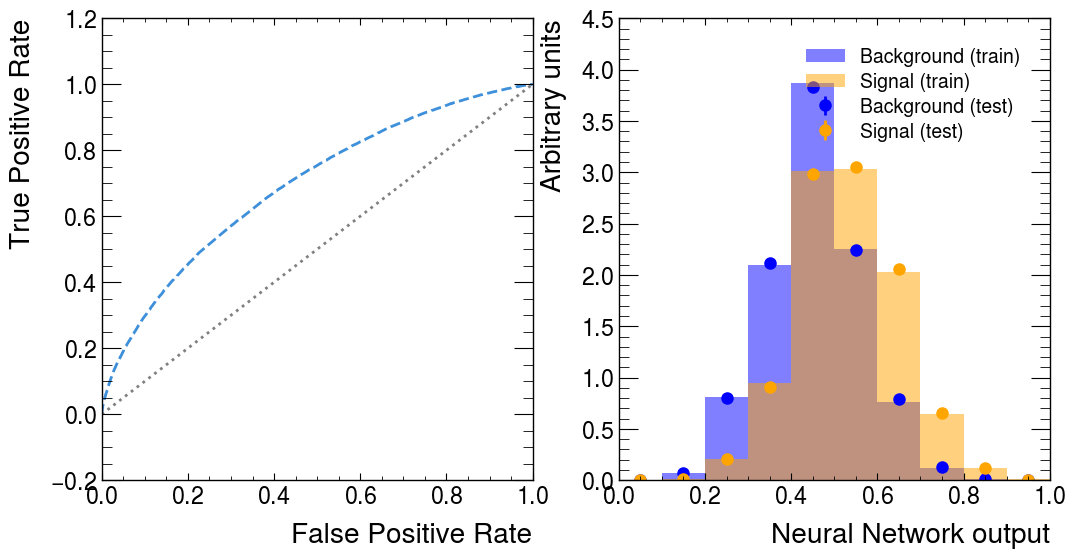

Accuracy Score: 0.6333
AUC Score: 0.691721
              precision    recall  f1-score   support

         0.0       0.60      0.68      0.64     52635
         1.0       0.67      0.59      0.63     58794

    accuracy                           0.63    111429
   macro avg       0.64      0.64      0.63    111429
weighted avg       0.64      0.63      0.63    111429

Confusion Matrix: 
[[35925 16710]
 [24150 34644]]
Precision: 0.6746
Recall: 0.5892
F1-Score: 0.629
Area under the Precision-Recall Curve: 0.6142


In [237]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_jets, tpr_nn_jets, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_jets, X_train_scaled_jets, y_train_jets, X_test_scaled_jets, y_test_jets, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_jets, y_pred_NN_jets):.4g}")
print(f"AUC Score: {auc_score_jets:.6g}")
print(classification_report(y_test_jets,y_pred_NN_jets))
print(f"Confusion Matrix: \n{cm_jets}")
print(f"Precision: {precision_jets:.4g}")
print(f"Recall: {recall_jets:.4g}")
print(f"F1-Score: {f1_jets:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_jets:.4g}")

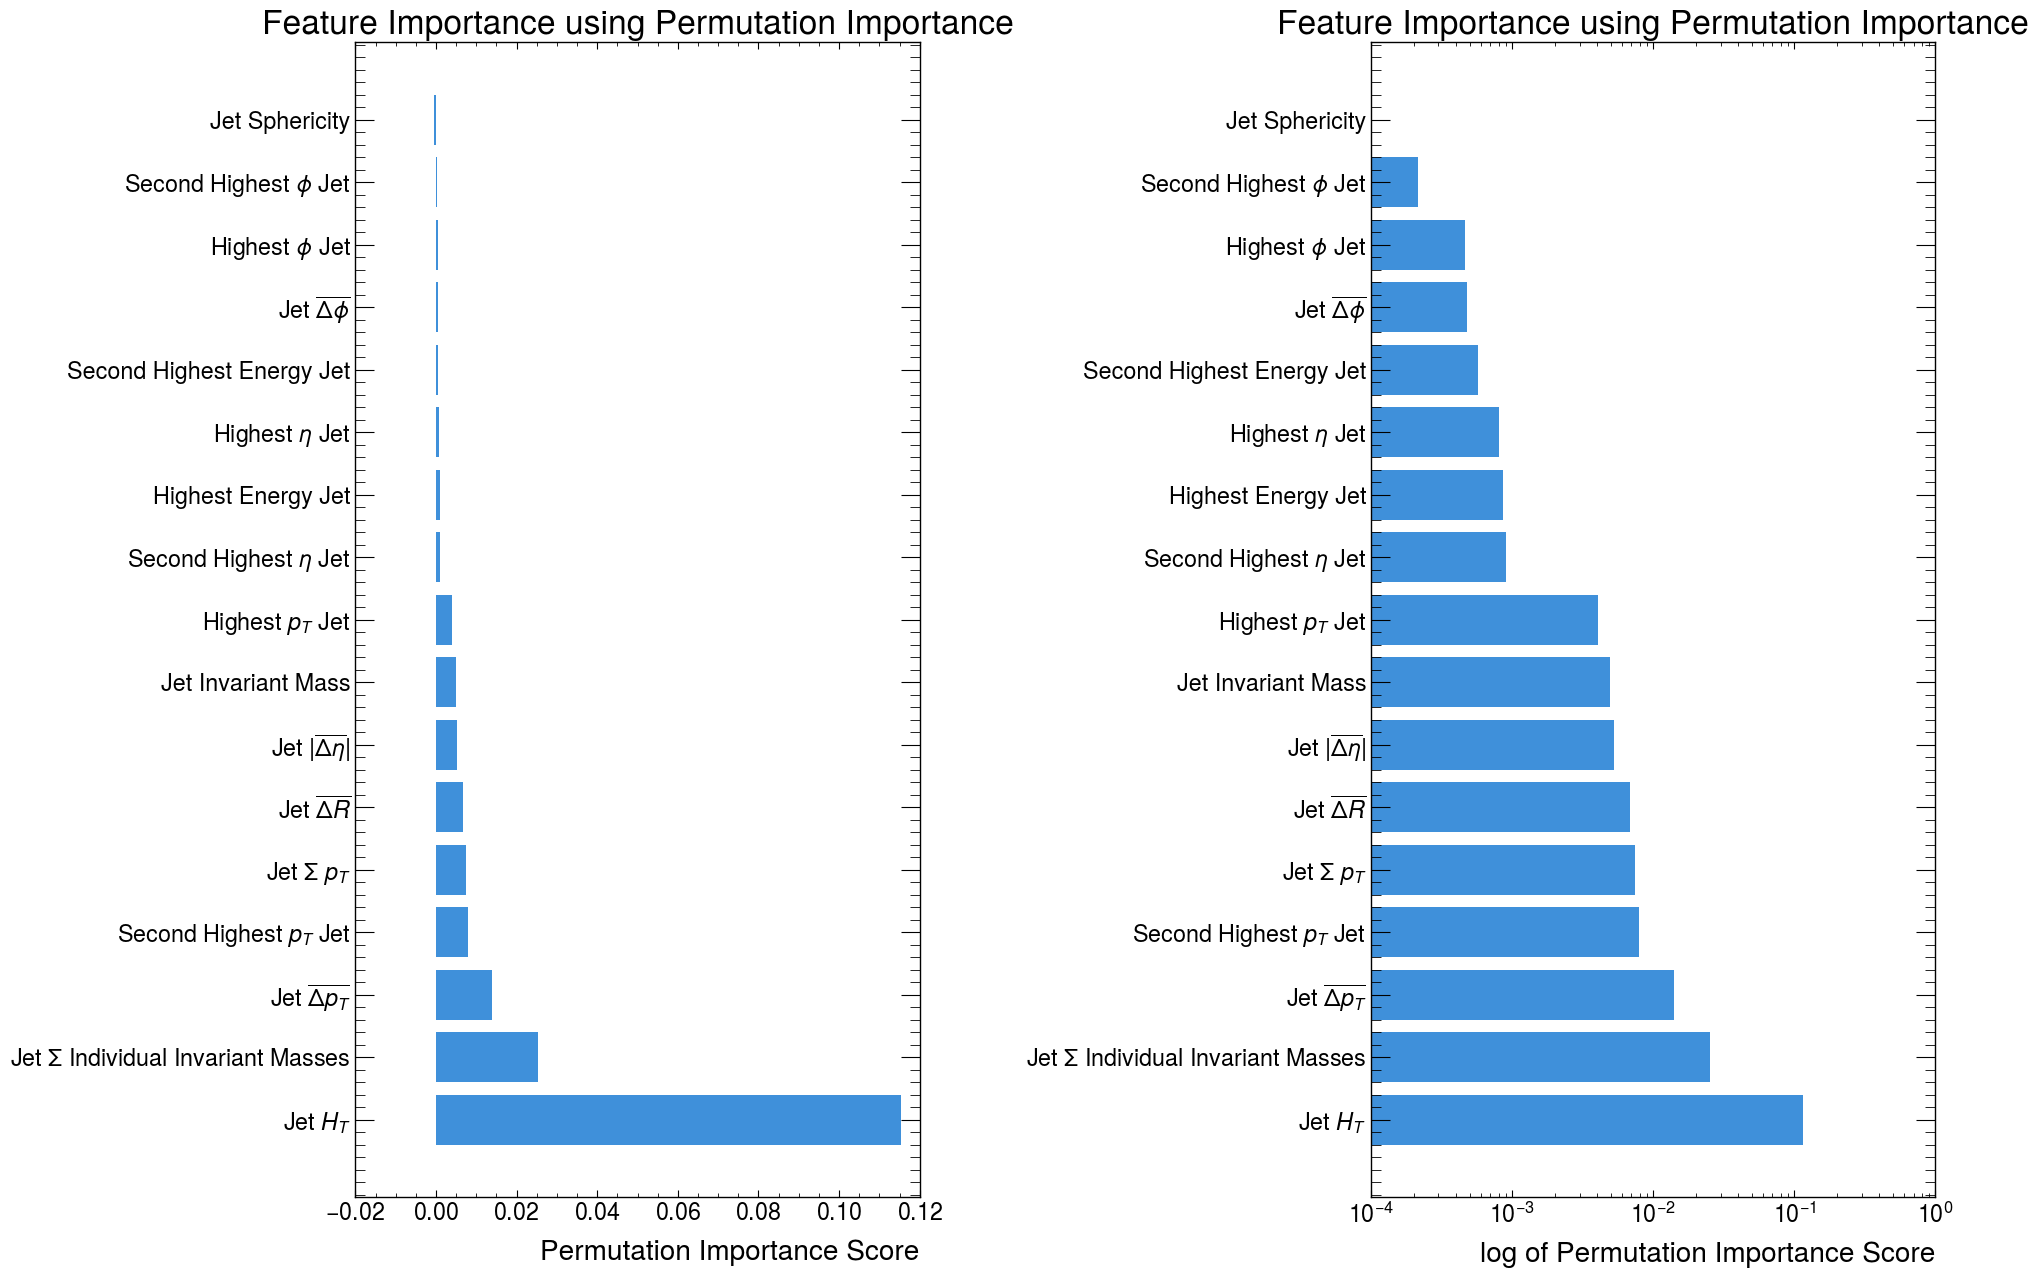

In [238]:
results_jets = permutation_importance(NN_clf_jets, X_test_tensor_jets, y_test_tensor_jets, n_repeats=30, random_state=42)
feature_names_jets = variable_names_jets_reduced

importance_scores_jets = results_jets.importances_mean

feature_importance_jets = sorted(zip(importance_scores_jets), reverse=True)

sorted_indices_jets = np.argsort(importance_scores_jets)[::-1]

sorted_importance_scores_jets = importance_scores_jets[sorted_indices_jets]
sorted_feature_names_jets = np.array(feature_names_jets)[sorted_indices_jets]
fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_jets, sorted_importance_scores_jets, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_jets, sorted_importance_scores_jets, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.8)
plt.show()

### All Reco

In [239]:
X_reco = trans_combined_data_jets_reduced
y_reco = labels_jets

X_train_reco, X_test_reco, y_train_reco, y_test_reco = train_test_split(X_reco, y_reco, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_reco)

X_train_scaled_reco = scaler.transform(X_train_reco)
X_test_scaled_reco = scaler.transform(X_test_reco)
X_scaled_reco = scaler.transform(X_reco)

In [240]:
epochs = 10  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_reco[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [241]:
X_train_tensor_reco = torch.as_tensor(X_train_scaled_reco, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_reco = torch.as_tensor(y_train_reco, dtype=torch.long)  # make tensor from y_train

X_train_var_reco, y_train_var_reco = Variable(X_train_tensor_reco), Variable(y_train_tensor_reco)  # make variables from tensors

validation_length_reco = int(len(X_train_var_reco)/10)

X_valid_var_reco, y_valid_var_reco = (X_train_var_reco[:validation_length_reco],y_train_var_reco[:validation_length_reco],)  # get first 100 events for validation
X_train_nn_var_reco, y_train_nn_var_reco = (X_train_var_reco[validation_length_reco:],y_train_var_reco[validation_length_reco:],)  # get remaining events for training

train_data_reco = Data.TensorDataset(X_train_nn_var_reco, y_train_nn_var_reco)  # create training dataset
valid_data_reco = Data.TensorDataset(X_valid_var_reco, y_valid_var_reco)  # create validation dataset

train_loader_reco = Data.DataLoader(dataset=train_data_reco,batch_size=batch_size,shuffle=True,)
valid_loader_reco = Data.DataLoader(dataset=valid_data_reco,batch_size=batch_size,shuffle=True,)

In [242]:
NN_clf_reco = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_reco = torch.optim.Adam(NN_clf_reco.parameters(), lr=learning_rate)
NN_clf_reco.fit(train_loader_reco,valid_loader_reco,optimiser_reco)

Epoch: 1, Train Loss: 0.646675
Validation Loss: 0.640668, Validation Accuracy: 0.632763
Epoch: 2, Train Loss: 0.644630
Validation Loss: 0.646544, Validation Accuracy: 0.626088
Epoch: 3, Train Loss: 0.644346
Validation Loss: 0.634864, Validation Accuracy: 0.635150
Epoch: 4, Train Loss: 0.644132
Validation Loss: 0.636117, Validation Accuracy: 0.630111
Epoch: 5, Train Loss: 0.644100
Validation Loss: 0.644762, Validation Accuracy: 0.626133
Epoch: 6, Train Loss: 0.643730
Validation Loss: 0.662300, Validation Accuracy: 0.628078
Epoch: 7, Train Loss: 0.644220
Validation Loss: 0.643866, Validation Accuracy: 0.630774
Epoch: 8, Train Loss: 0.644008
Validation Loss: 0.644733, Validation Accuracy: 0.624188
Epoch: 9, Train Loss: 0.643968
Validation Loss: 0.643607, Validation Accuracy: 0.632807
Epoch: 10, Train Loss: 0.644303
Validation Loss: 0.639251, Validation Accuracy: 0.632365
Finished Training
Final validation error:  36.76347080404898 %


In [243]:
X_test_tensor_reco = torch.as_tensor(X_test_scaled_reco, dtype=torch.float)
y_test_tensor_reco = torch.as_tensor(y_test_reco, dtype=torch.long)

X_test_var_reco, y_test_var_reco = Variable(X_test_tensor_reco), Variable(y_test_tensor_reco)
out_reco, prob_reco = NN_clf_reco(X_test_var_reco)
y_pred_NN_reco = (prob_reco.cpu().detach().numpy().argmax(axis=1))

decisions_nn_reco = (NN_clf_reco(X_test_var_reco)[1][:, 1].cpu().detach().numpy())

fpr_nn_reco, tpr_nn_reco, thresholds_nn_reco = roc_curve(y_test_reco, decisions_nn_reco)

ams_nn_reco = AMS(tpr_nn_reco,fpr_nn_reco,b_reg)

auc_score_reco = roc_auc_score(y_test_reco,decisions_nn_reco)

cm_reco = confusion_matrix(y_test_reco, y_pred_NN_reco)
precision_reco = precision_score(y_test_reco, y_pred_NN_reco)
recall_reco = recall_score(y_test_reco, y_pred_NN_reco)
f1_reco = f1_score(y_test_reco, y_pred_NN_reco)
auc_pr_reco = average_precision_score(y_test_reco,y_pred_NN_reco)

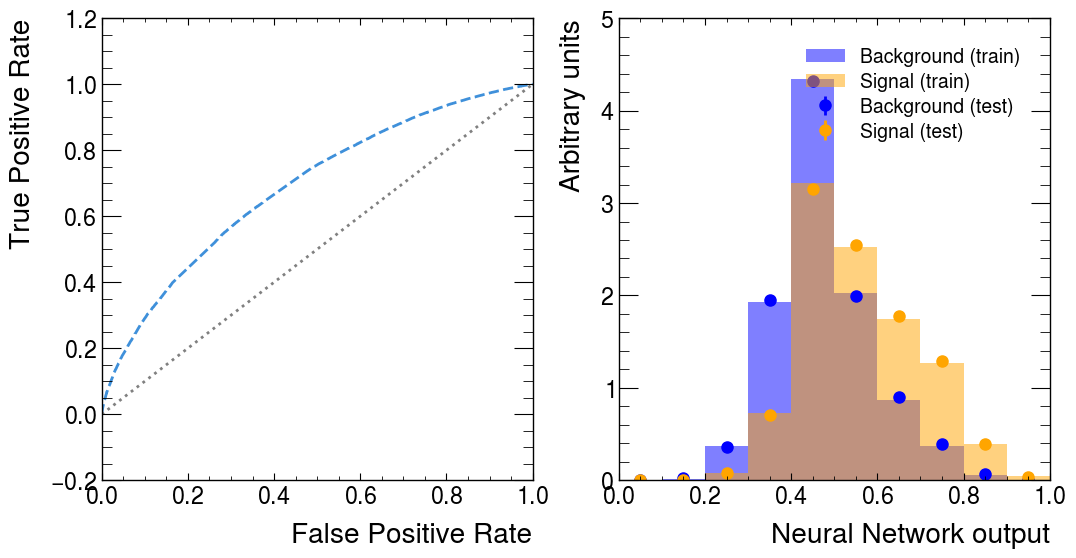

Accuracy Score: 0.6334
AUC Score: 0.68815
              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63     52635
         1.0       0.67      0.60      0.64     58794

    accuracy                           0.63    111429
   macro avg       0.63      0.64      0.63    111429
weighted avg       0.64      0.63      0.63    111429

Confusion Matrix: 
[[35008 17627]
 [23225 35569]]
Precision: 0.6686
Recall: 0.605
F1-Score: 0.6352
Area under the Precision-Recall Curve: 0.6129


In [244]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_reco, tpr_nn_reco, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_reco, X_train_scaled_reco, y_train_reco, X_test_scaled_reco, y_test_reco, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_reco, y_pred_NN_reco):.4g}")
print(f"AUC Score: {auc_score_reco:.6g}")
print(classification_report(y_test_reco,y_pred_NN_reco))
print(f"Confusion Matrix: \n{cm_reco}")
print(f"Precision: {precision_reco:.4g}")
print(f"Recall: {recall_reco:.4g}")
print(f"F1-Score: {f1_reco:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_reco:.4g}")

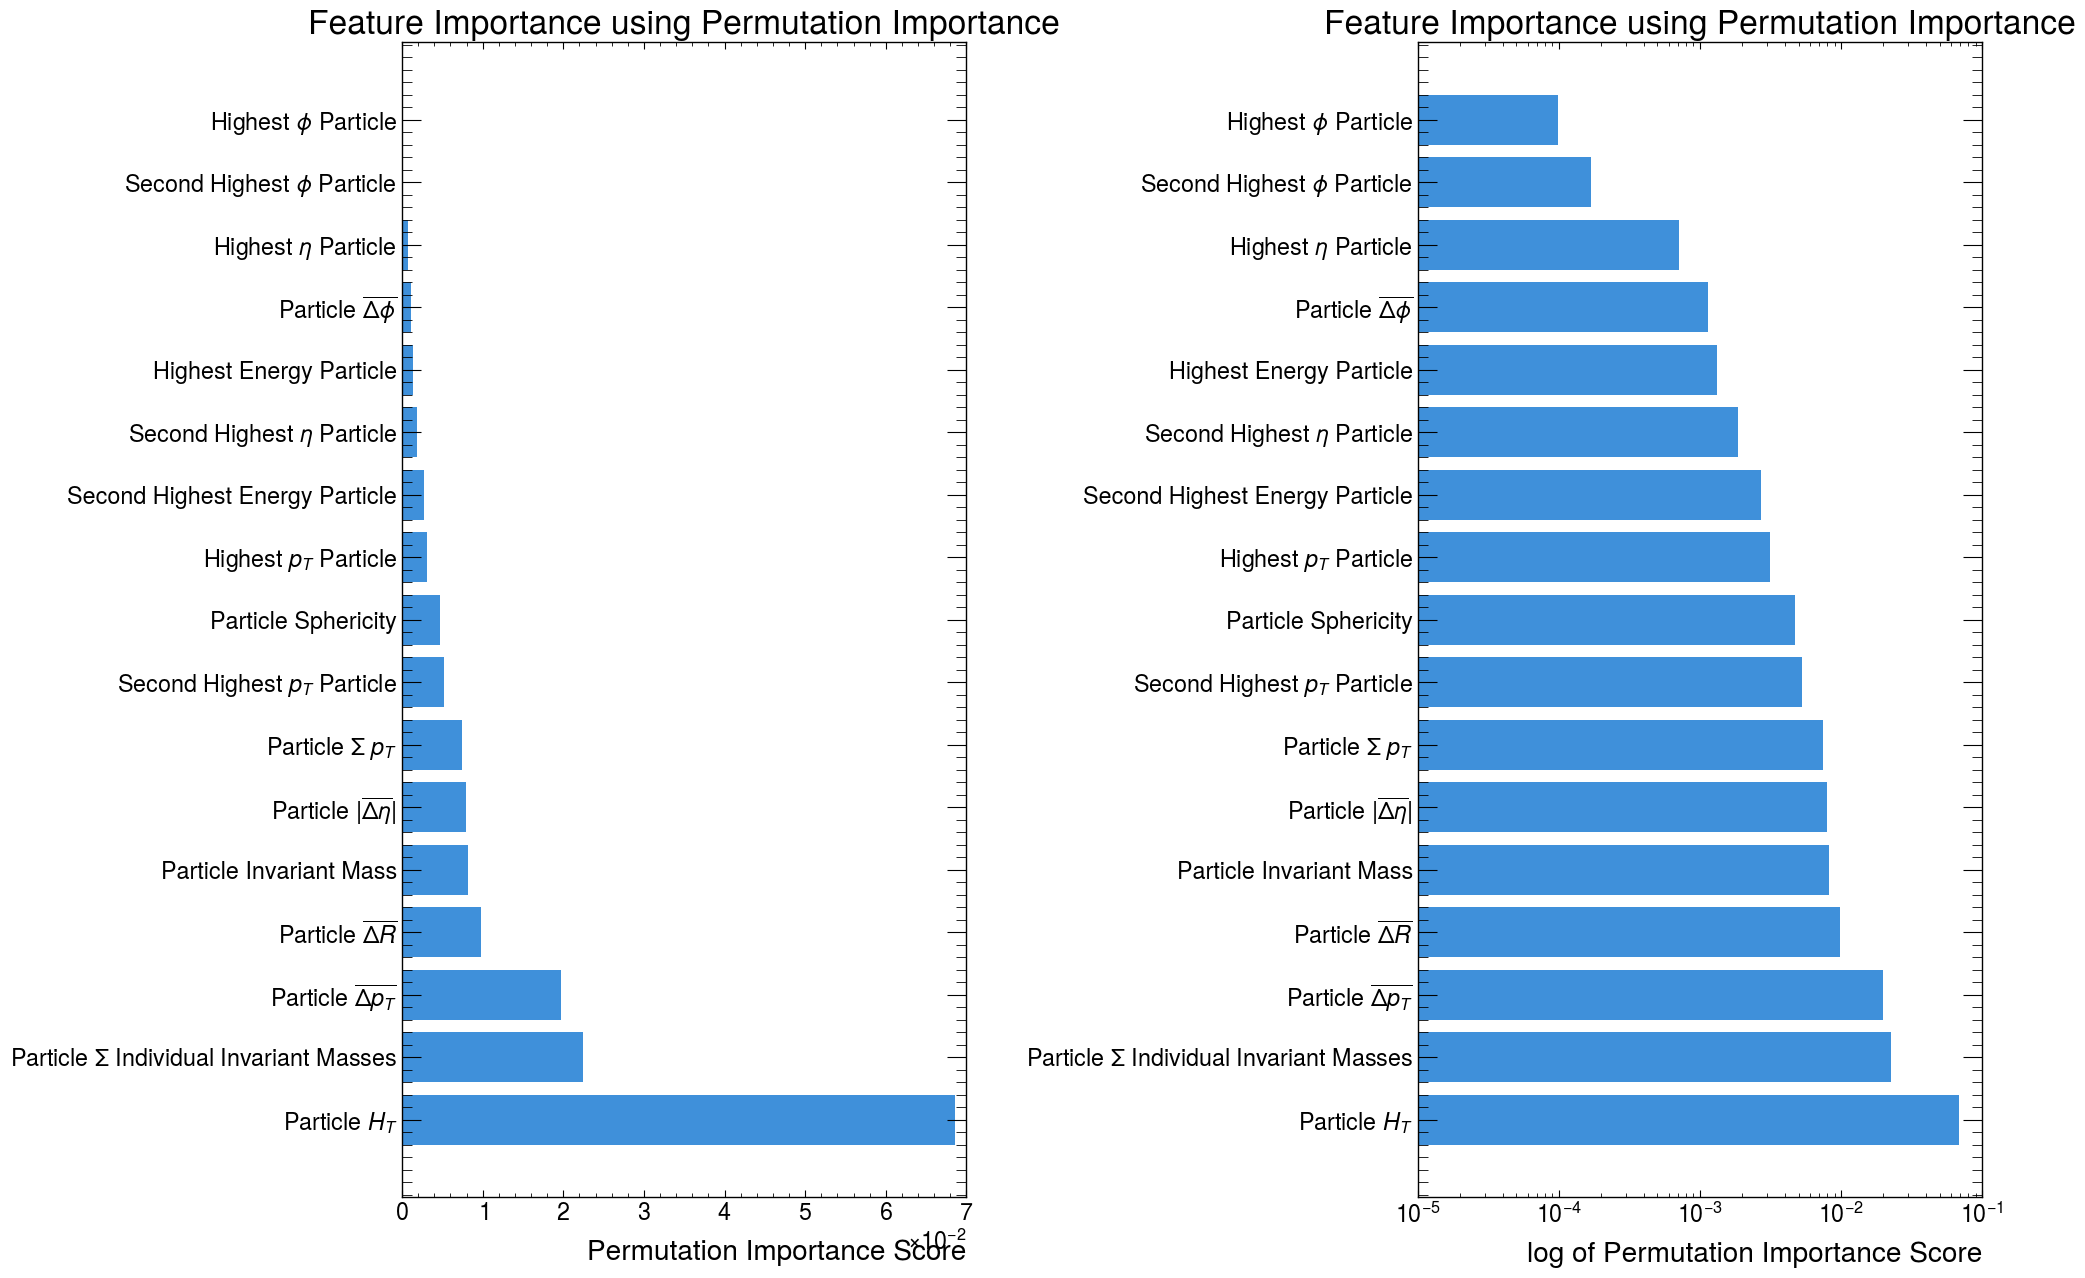

In [245]:
results_reco = permutation_importance(NN_clf_reco, X_test_tensor_reco, y_test_tensor_reco, n_repeats=30, random_state=42)
feature_names_reco = variable_names_reco_reduced

importance_scores_reco = results_reco.importances_mean

feature_importance_reco = sorted(zip(importance_scores_reco), reverse=True)

sorted_indices_reco = np.argsort(importance_scores_reco)[::-1]

sorted_importance_scores_reco = importance_scores_reco[sorted_indices_reco]
sorted_feature_names_reco = np.array(feature_names_reco)[sorted_indices_reco]
fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_reco, sorted_importance_scores_reco, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_reco, sorted_importance_scores_reco, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.8)
plt.show()

### Partonic

In [246]:
X_partonic = trans_partonic_data_reduced
y_partonic = labels_partonic

X_train_partonic, X_test_partonic, y_train_partonic, y_test_partonic = train_test_split(X_partonic, y_partonic, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic)

X_train_scaled_partonic = scaler.transform(X_train_partonic)
X_test_scaled_partonic = scaler.transform(X_test_partonic)
X_scaled_partonic = scaler.transform(X_partonic)

In [247]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic[0,:])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [248]:
X_train_tensor_partonic = torch.as_tensor(X_train_scaled_partonic, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic = torch.as_tensor(y_train_partonic, dtype=torch.long)  # make tensor from y_train
X_train_var_partonic, y_train_var_partonic = Variable(X_train_tensor_partonic), Variable(y_train_tensor_partonic)  # make variables from tensors

validation_length_partonic = int(len(X_train_var_partonic)/10)

X_valid_var_partonic, y_valid_var_partonic = (X_train_var_partonic[:validation_length_partonic],y_train_var_partonic[:validation_length_partonic],)  # get first 100 events for validation
X_train_nn_var_partonic, y_train_nn_var_partonic = (X_train_var_partonic[validation_length_partonic:],y_train_var_partonic[validation_length_partonic:],)  # get remaining events for training

train_data_partonic = Data.TensorDataset(X_train_nn_var_partonic, y_train_nn_var_partonic)  # create training dataset
valid_data_partonic = Data.TensorDataset(X_valid_var_partonic, y_valid_var_partonic)  # create validation dataset
train_loader_partonic = Data.DataLoader(dataset=train_data_partonic,batch_size=batch_size,shuffle=True,)
valid_loader_partonic = Data.DataLoader(dataset=valid_data_partonic,batch_size=batch_size,shuffle=True,)

In [249]:
NN_clf_partonic = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic = torch.optim.Adam(NN_clf_partonic.parameters(), lr=learning_rate)
NN_clf_partonic.fit(train_loader_partonic,valid_loader_partonic,optimiser_partonic)

Epoch: 1, Train Loss: 0.475391
Validation Loss: 0.367186, Validation Accuracy: 0.785311
Epoch: 2, Train Loss: 0.203728
Validation Loss: 0.170665, Validation Accuracy: 0.937853
Epoch: 3, Train Loss: 0.111857
Validation Loss: 0.139337, Validation Accuracy: 0.943503
Epoch: 4, Train Loss: 0.086357
Validation Loss: 0.130710, Validation Accuracy: 0.949153
Epoch: 5, Train Loss: 0.070694
Validation Loss: 0.127457, Validation Accuracy: 0.960452
Epoch: 6, Train Loss: 0.060900
Validation Loss: 0.112869, Validation Accuracy: 0.960452
Epoch: 7, Train Loss: 0.050083
Validation Loss: 0.099014, Validation Accuracy: 0.954802
Epoch: 8, Train Loss: 0.041628
Validation Loss: 0.088717, Validation Accuracy: 0.966102
Epoch: 9, Train Loss: 0.033345
Validation Loss: 0.077487, Validation Accuracy: 0.971751
Epoch: 10, Train Loss: 0.026339
Validation Loss: 0.077082, Validation Accuracy: 0.966102
Epoch: 11, Train Loss: 0.022133
Validation Loss: 0.067010, Validation Accuracy: 0.971751
Epoch: 12, Train Loss: 0.01870

In [250]:
X_test_tensor_partonic = torch.as_tensor(X_test_scaled_partonic, dtype=torch.float)
y_test_tensor_partonic = torch.as_tensor(y_test_partonic, dtype=torch.long)

X_test_var_partonic, y_test_var_partonic = Variable(X_test_tensor_partonic), Variable(y_test_tensor_partonic)
out_partonic,prob_partonic = NN_clf_partonic(X_test_var_partonic)
y_pred_NN_partonic = (prob_partonic.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic = (NN_clf_partonic(X_test_var_partonic)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic, tpr_nn_partonic, thresholds_nn_partonic = roc_curve(y_test_partonic, decisions_nn_partonic)

ams_nn_partonic = AMS(tpr_nn_partonic,fpr_nn_partonic,b_reg)

auc_score_partonic = roc_auc_score(y_test_partonic,decisions_nn_partonic)

cm_partonic = confusion_matrix(y_test_partonic, y_pred_NN_partonic)
precision_partonic = precision_score(y_test_partonic, y_pred_NN_partonic)
recall_partonic = recall_score(y_test_partonic, y_pred_NN_partonic)
f1_partonic = f1_score(y_test_partonic, y_pred_NN_partonic)
auc_pr_partonic = average_precision_score(y_test_partonic,y_pred_NN_partonic)

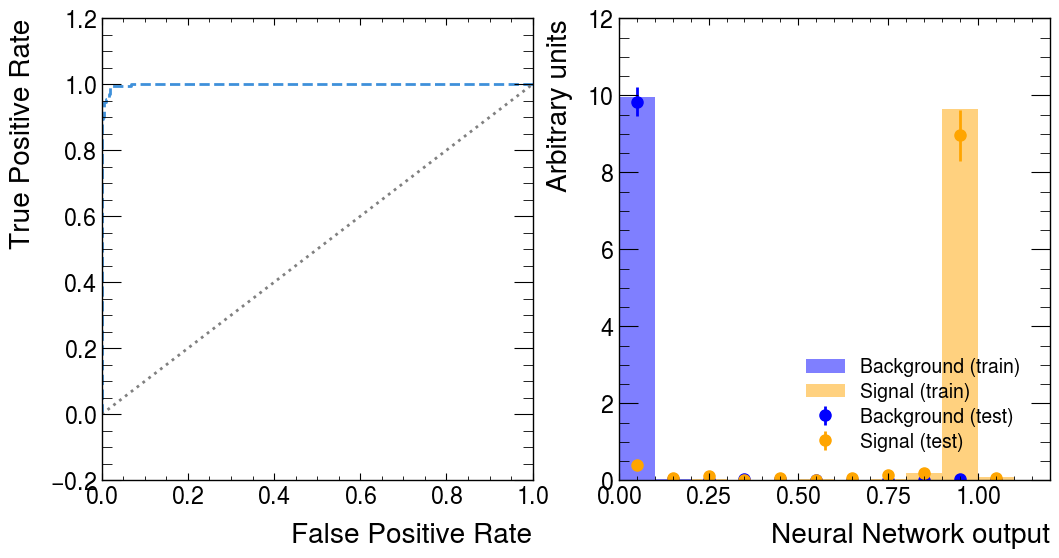

Accuracy Score: 0.9829
AUC Score: 0.998566
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       673
         1.0       0.98      0.94      0.96       202

    accuracy                           0.98       875
   macro avg       0.98      0.97      0.98       875
weighted avg       0.98      0.98      0.98       875

Confusion Matrix: 
[[670   3]
 [ 12 190]]
Precision: 0.9845
Recall: 0.9406
F1-Score: 0.962
Area under the Precision-Recall Curve: 0.9397


In [252]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_partonic, tpr_nn_partonic, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_partonic, X_train_scaled_partonic, y_train_partonic, X_test_scaled_partonic, y_test_partonic, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic, y_pred_NN_partonic):.4g}")
print(f"AUC Score: {auc_score_partonic:.6g}")
print(classification_report(y_test_partonic,y_pred_NN_partonic))
print(f"Confusion Matrix: \n{cm_partonic}")
print(f"Precision: {precision_partonic:.4g}")
print(f"Recall: {recall_partonic:.4g}")
print(f"F1-Score: {f1_partonic:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic:.4g}")

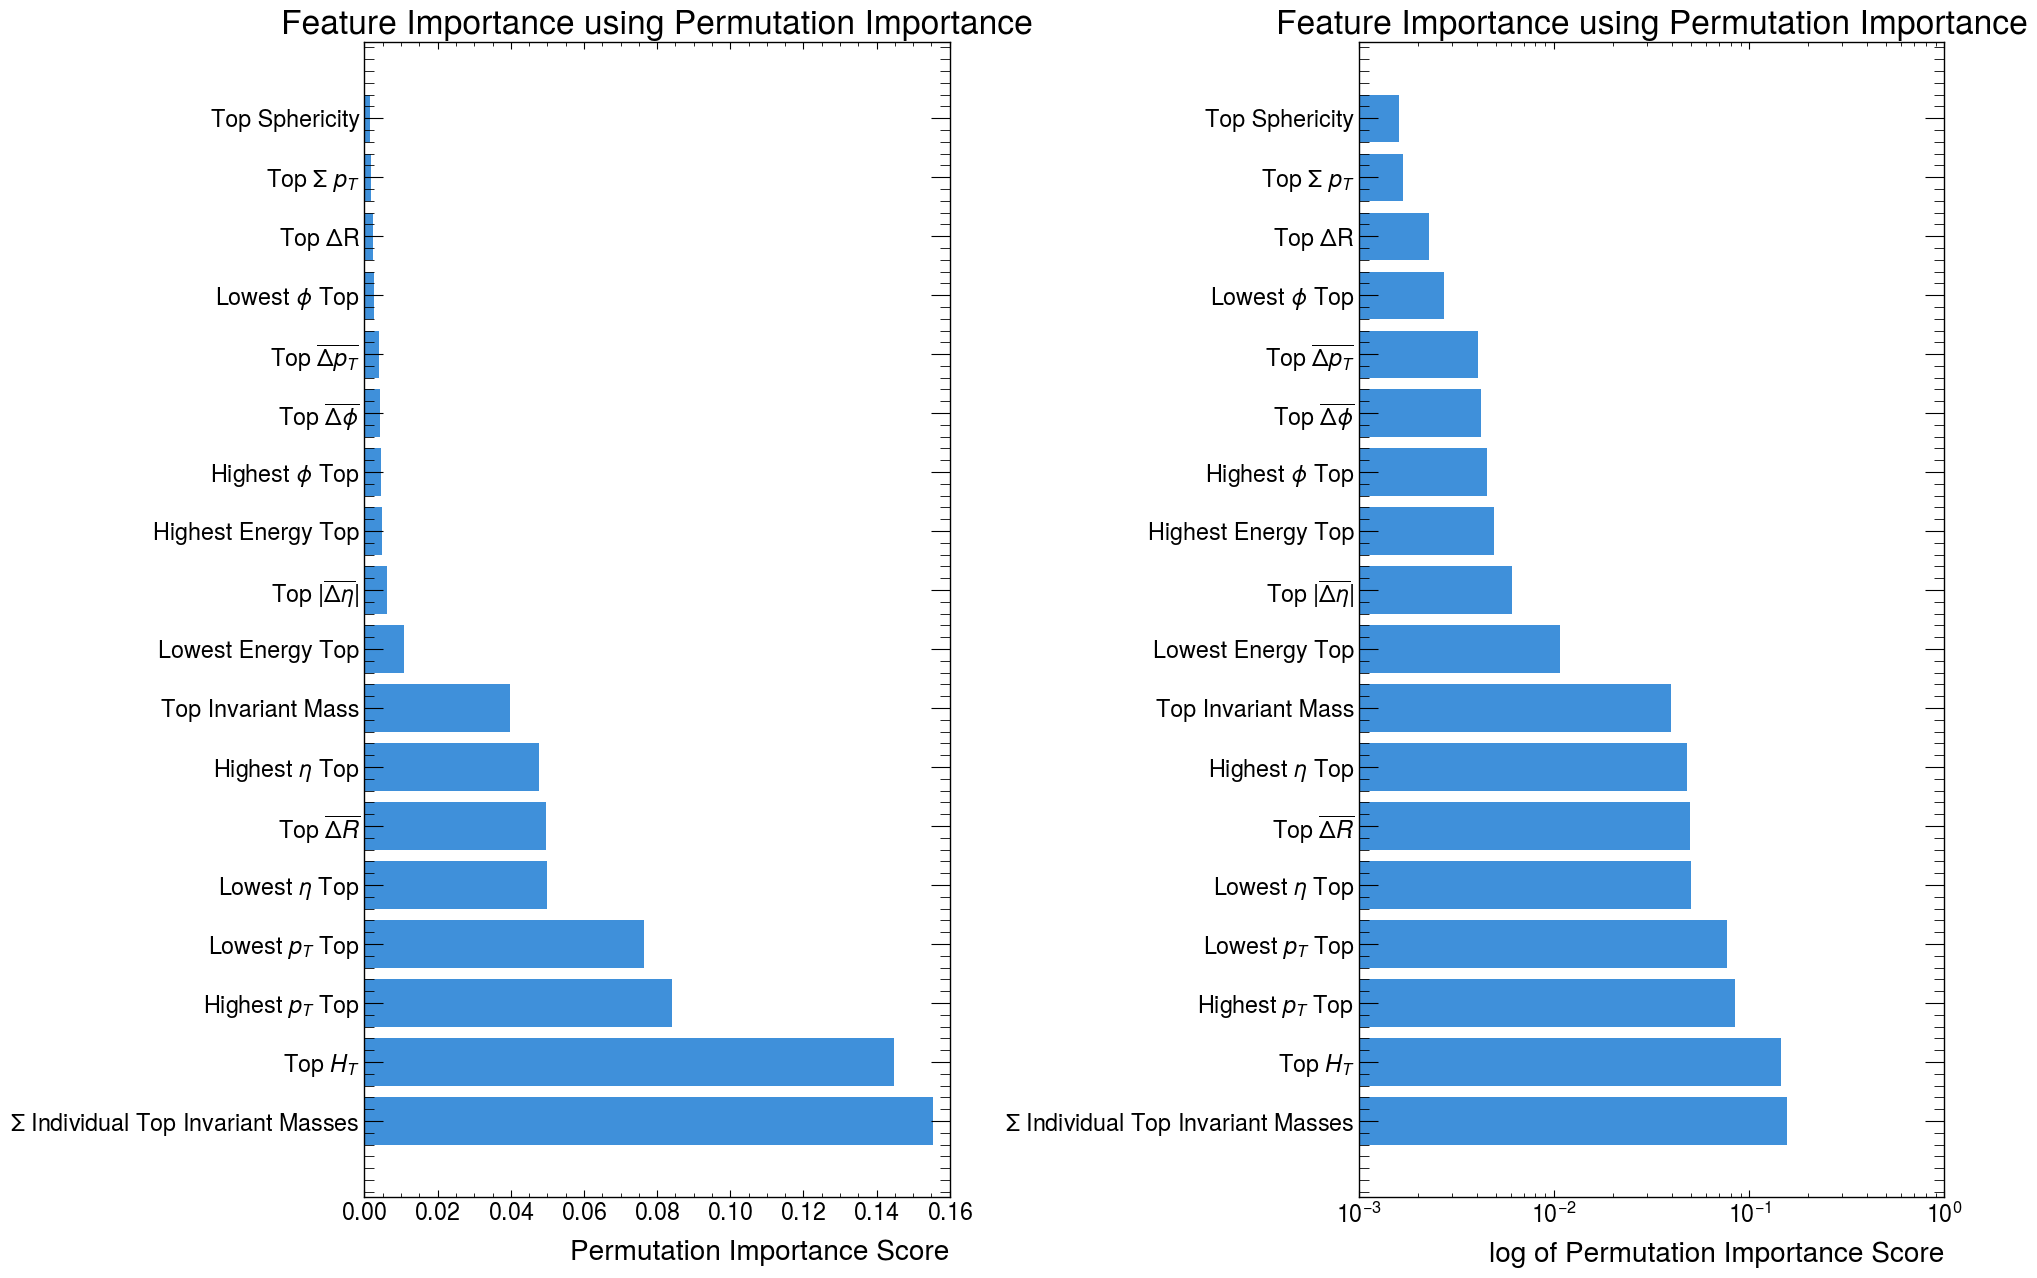

In [253]:
results_partonic = permutation_importance(NN_clf_partonic, X_test_tensor_partonic, y_test_tensor_partonic, n_repeats=30, random_state=42)
feature_names_partonic = variable_names_partonic_reduced

importance_scores_partonic = results_partonic.importances_mean

feature_importance_partonic = sorted(zip(importance_scores_partonic), reverse=True)

sorted_indices_partonic = np.argsort(importance_scores_partonic)[::-1]

sorted_importance_scores_partonic = importance_scores_partonic[sorted_indices_partonic]
sorted_feature_names_partonic = np.array(feature_names_partonic)[sorted_indices_partonic]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic, sorted_importance_scores_partonic, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic, sorted_importance_scores_partonic, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

ValueError: ax must be a matplotlib Axes object

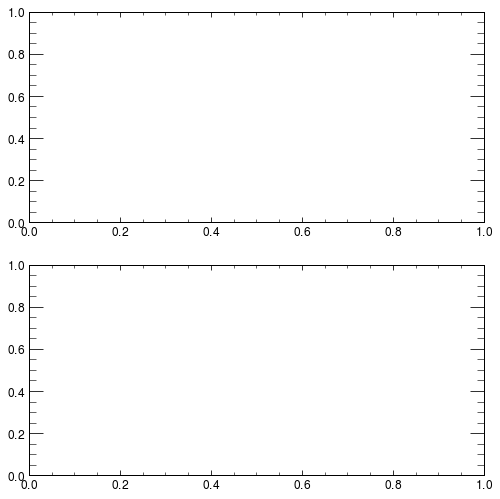

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8))
histogram([tops_4t_H_t,tops_3t_H_t], 15, ['4t', '3t'], ax, density = False, x_units='GeV')
ax.set_xlabel(r'Top $H_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()